# **Emotion Detection**

# **1. Introduction**

Emotion recognition from facial expressions is a key task in the field of computer vision and affective computing.  
It has broad applications in areas such as human-computer interaction, healthcare, security, marketing, and education — wherever understanding human emotions can enhance interactions or decision-making.

Despite the intuitive nature of facial emotion recognition for humans, automating this process remains challenging due to factors such as facial diversity, expression subtlety, occlusions, lighting conditions, and cultural variations.

The core problem addressed in this project is the automatic classification of emotions from static facial images.  
We aim to train models that can accurately recognize one of seven fundamental emotions based solely on visual cues. This task requires the model to extract and interpret subtle facial features under varying conditions, without relying on contextual or verbal information.

To develop and evaluate our models, we use the **FER-2013** dataset — a widely used benchmark introduced in the 2013 ICML (International Conference on Machine Learning) Challenge.  
The dataset contains **35,887 grayscale images** of size **48×48 pixels**, each labeled with one of seven basic emotions: *angry, disgusted, fearful, happy, neutral, sad,* and *surprised*.  
The images labeled by human annotators. The dataset is divided into training and test sets, and is known for its variability and noise, making it a challenging and realistic benchmark for emotion classification.

Our approach includes:
- Preprocessing the dataset and performing exploratory data analysis (EDA)
- Testing multiple feature extraction strategies: raw grayscale, Sobel edge filtering, and HOG (Histogram of Oriented Gradients)
- Training and evaluating three different models: Support Vector Machine (SVM), Convolutional Neural Network (CNN), and EfficientNet (transfer learning)
- Applying the trained models to real-world personal images for qualitative assessment

Through this process, we aim to examine which modeling approach performs best, understand the model’s strengths and weaknesses across emotion classes, and evaluate its generalization capability to data beyond the training distribution.

# **2. Imports**

### In this section, we import all the necessary libraries for data manipulation, image processing, machine learning, and deep learning.
### These libraries will support the various stages of our workflow, including data preprocessing, visualization, model building, and evaluation.


In [65]:
# === Standard Libraries ===
import os
import random
import hashlib
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# === Data Analysis & Visualization ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Image Processing ===
import cv2
from PIL import Image
from skimage import exposure, filters, color
from skimage.feature import hog

# === Progress Bar ===
from tqdm.notebook import tqdm

# === Scikit-Learn ===
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report
)
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam

# === Dataset Download ===
import kagglehub
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

# **3. Data Loading**


### In this section, we loaded the FER-2013 dataset from the local directory structure, where images are stored in folders named after their corresponding emotion labels. A custom function was implemented to traverse these folders and collect image paths along with their labels.
### The data was then organized into DataFrames for both training and test sets, with the training data shuffled to ensure a randomized distribution before further processing.




In [2]:
def load_dataset(directory):
    """
    Loads images and labels from the folder.

    Arguments:
    directory (str): Path to the main folder of the dataset.

    Returns:
    image_paths (list): A list of paths to the images.
    labels (list): A list of labels corresponding to each image.
    """
    image_paths = []
    labels = []

    for label in os.listdir(directory): # Open the dir of each label
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):  # Loop over files in label folder
                image_path = os.path.join(label_path, filename)
                image_paths.append(image_path)
                labels.append(label)

    return image_paths, labels

# Path to the dataset directories
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

# Convert train data into DataFrame
train = pd.DataFrame()
train['image path'], train['label'] = load_dataset(train_dir)

# Shuffle the dataset before splitting
train_df = train.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert test data into DataFrame
test = pd.DataFrame()
test['image path'], test['label'] = load_dataset(test_dir)

# Reset index for test data
test = test.reset_index(drop=True)

# Display one example image for each emotion
unique_labels = train['label'].unique()

# Display first few rows of train DataFrame for verification
print("\nTrain DataFrame for example:")
train_df.head()


Train DataFrame for example:


,image path,label
0,/root/.cache/kagglehub/datasets/ananthu017/emo...,happy
1,/root/.cache/kagglehub/datasets/ananthu017/emo...,neutral
2,/root/.cache/kagglehub/datasets/ananthu017/emo...,fearful
3,/root/.cache/kagglehub/datasets/ananthu017/emo...,happy
4,/root/.cache/kagglehub/datasets/ananthu017/emo...,fearful


# **4. EDA - Exploratory Data Analysis**

### Before training the model, we will perform exploratory data analysis to better understand the structure and quality of the dataset.  
### We will examine label distribution, inspect image properties, identify anomalies, and clean the data.  
### These steps will help ensure that the dataset is balanced, consistent, and free from noise — which will improve model performance later on.

## Initial analysis of the data:

#### We perform an initial exploration of the FER-2013 dataset to better understand its structure and quality. This includes checking the size and label distribution, viewing sample images, verifying uniform image dimensions, and analyzing brightness and contrast. These steps help ensure the dataset is suitable for model training.

We begin the exploratory analysis by examining the overall size of the dataset and the distribution of emotion classes within the training set. A pie chart is used to visualize the proportion between training and test samples, while a bar chart shows the frequency of each emotion label.


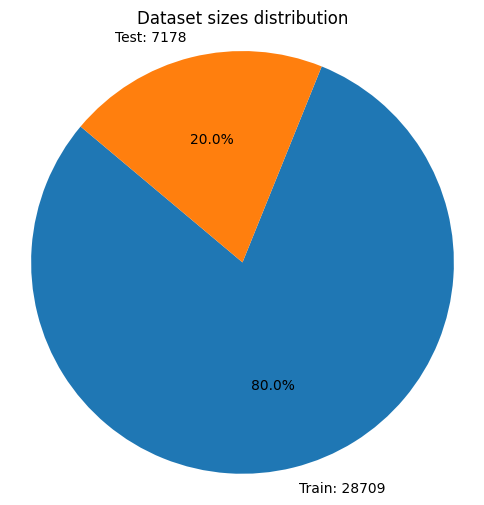

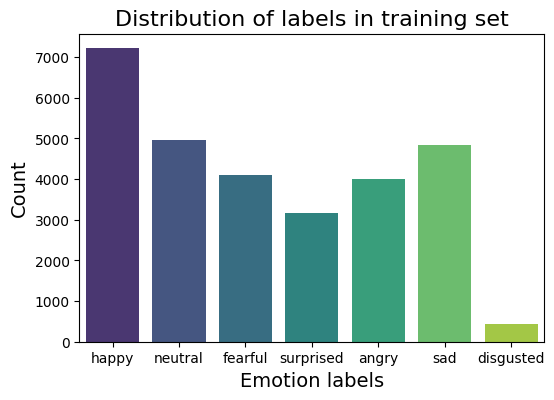

In [3]:
# Dataset sizes
dataset_sizes = [len(train_df), len(test)]
dataset_labels = ['Train', 'Test']

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(dataset_sizes, labels=[f"{label}: {size}" for label, size in zip(dataset_labels, dataset_sizes)], autopct='%1.1f%%', startangle=140)
plt.title('Dataset sizes distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Print a plot that visualizes the distribution of emotion labels in the train dataset.
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='label', palette='viridis')
plt.xticks(rotation=0)
plt.title("Distribution of labels in training set", fontsize=16)
plt.xlabel("Emotion labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


To better understand the data, we visualize a few sample images. First, we display a single image to observe its size and format (48x48 pixels). Then, we present one example image for each emotion category to get a sense of visual differences between classes.


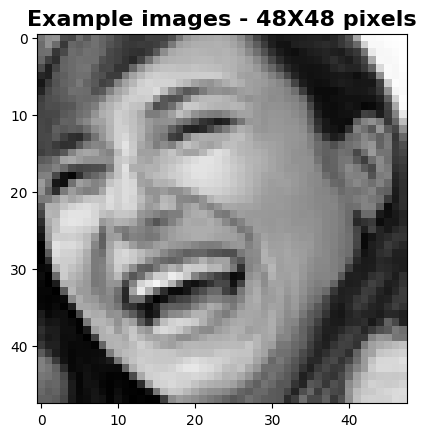

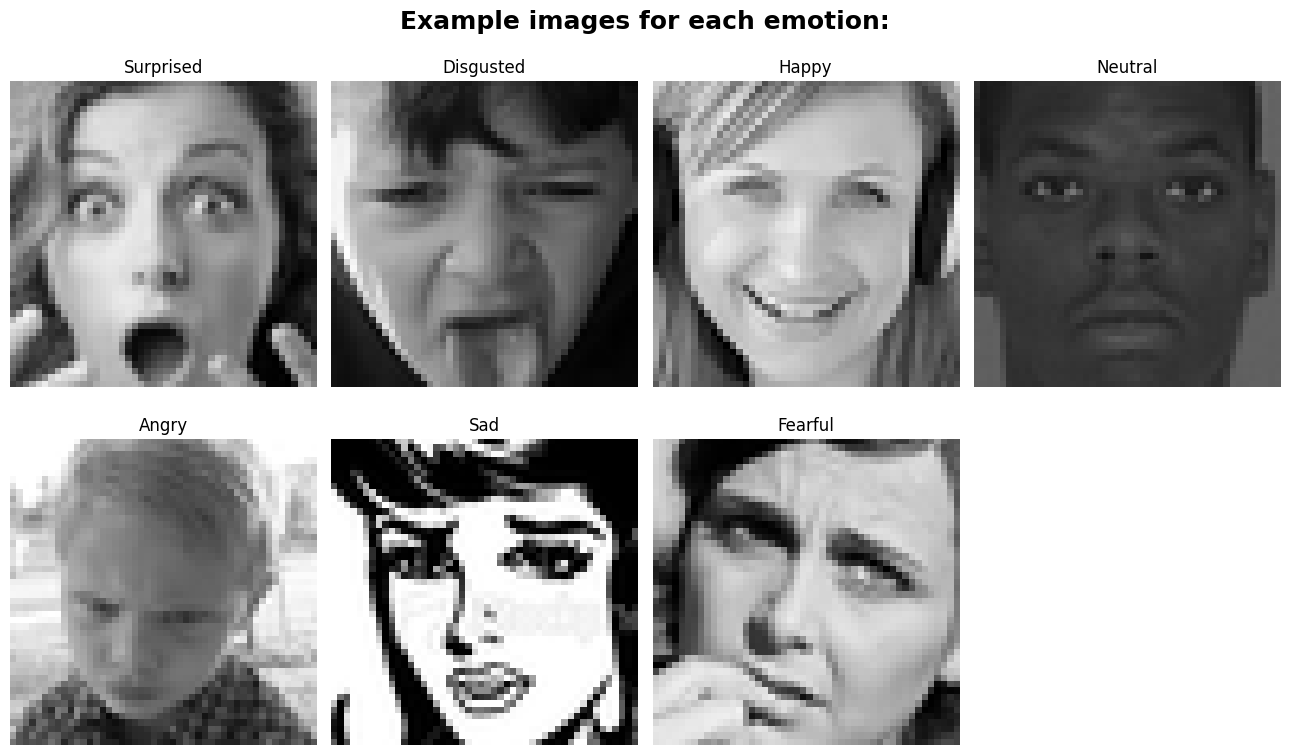

In [4]:
# display one photo for example
img = Image.open(train_df['image path'][0])
plt.imshow(img, cmap='gray')

# Add the title to the plot
plt.title("Example images - 48X48 pixels", fontsize=16, weight='bold')
plt.show()

# Print one example for each emotion
plt.figure(figsize=(13, 8))

for i, label in enumerate(unique_labels):
    # Get the first image path for the current label
    image_path = train[train['label'] == label]['image path'].iloc[0]

    # Load and convert the image to RGB
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add subplot for each emotion
    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(label.capitalize())  # Capitalize the label for display
    plt.axis('off')

# Add a title to the entire plot
plt.suptitle("Example images for each emotion:", fontsize=18, weight='bold')
plt.tight_layout()
plt.show()

We analyze the distribution of image dimensions (width and height) in the training set to confirm that the dataset is uniform in size. This is important for consistent input to the neural network.


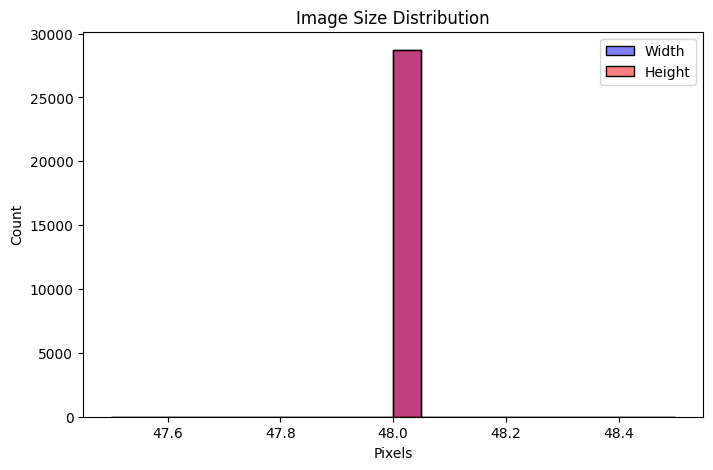

In [5]:
# Analyze the distribution of image widths and heights in the training dataset
image_shapes = [Image.open(img).size for img in train_df['image path']]
widths, heights = zip(*image_shapes)

plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=20, kde=True, color='blue', label='Width')
sns.histplot(heights, bins=20, kde=True, color='red', label='Height')
plt.legend()
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.show()

All images in the training set were found to have consistent dimensions of 48x48 pixels.  
This uniformity ensures compatibility with convolutional neural network models without requiring additional resizing or cropping.

To understand the overall visual characteristics of the dataset, we analyze the brightness and contrast levels across all training images. This helps identify potential issues such as poor lighting or low contrast that could affect model performance.

Processing Brightness & Contrast:   0%|          | 0/28709 [00:00<?, ?it/s]

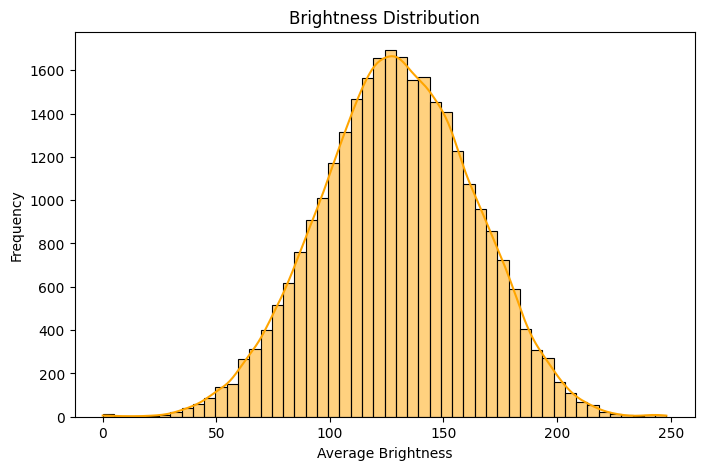

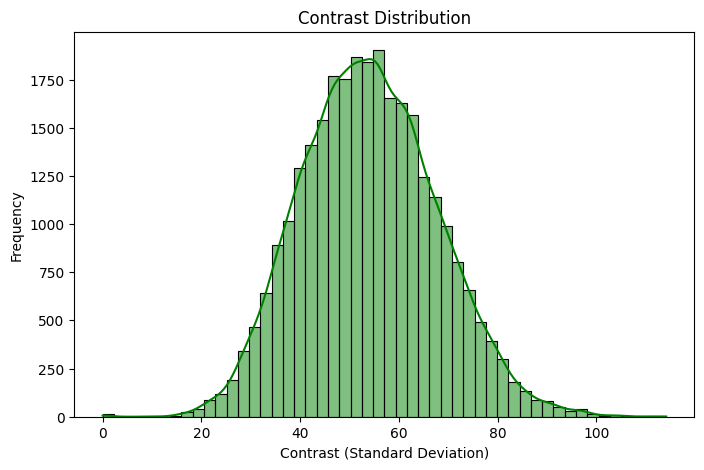

In [6]:
# Calculate and visualize the brightness and contrast distributions of images in the training dataset.
brightness_values = []
contrast_values = []

# Loop through each image path and compute average brightness and standard deviation (contrast)
for img_path in tqdm(train_df['image path'], desc="Processing Brightness & Contrast"):
    img = np.array(Image.open(img_path))
    brightness_values.append(np.mean(img))     # Average brightness per image
    contrast_values.append(np.std(img))        # Standard deviation as a measure of contrast

# Plot brightness distribution
plt.figure(figsize=(8, 5))
sns.histplot(brightness_values, bins=50, kde=True, color='orange')
plt.title("Brightness Distribution")
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.show()

# Plot contrast distribution
plt.figure(figsize=(8, 5))
sns.histplot(contrast_values, bins=50, kde=True, color='green')
plt.title("Contrast Distribution")
plt.xlabel("Contrast (Standard Deviation)")
plt.ylabel("Frequency")
plt.show()

The brightness distribution across the training images follows a near-normal (bell-shaped) distribution centered around a mean brightness value of approximately 125.  
This indicates that most images have a moderate level of brightness.  
The contrast distribution, measured by the standard deviation of pixel intensities, also shows a fairly balanced spread. These results suggest that the dataset has overall good visual quality with no extreme lighting conditions that could hinder model performance.

## Anomaly detection:

#### In this section, we identify and remove potential anomalies that may negatively impact model performance. We start by checking for corrupted and duplicate images.
#### Then, we analyze brightness and contrast distributions to detect outlier images. Finally, we apply unsupervised clustering (DBSCAN) to group visually similar images and filter out redundancy while retaining diversity.
#### These steps help improve dataset quality and reduce noise before training.

We begin anomaly detection by checking for corrupted or unreadable image files using PIL's built-in verification. Any such images are removed from the dataset.

In [7]:
def check_corrupt_images(image_paths):
    corrupt_images = []
    for img_path in tqdm(image_paths, desc="Checking corrupt images"):
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError):
            corrupt_images.append(img_path)

    return corrupt_images

# Check for corrupted images in training and test sets
corrupt_train = check_corrupt_images(train_df['image path'])
corrupt_test = check_corrupt_images(test['image path'])

# Print the results
print(f"Found {len(corrupt_train)} corrupt images in training set.")
print(f"Found {len(corrupt_test)} corrupt images in test set.")

# Remove corrupt images from DataFrames
train_df = train_df[~train_df['image path'].isin(corrupt_train)]
test = test[~test['image path'].isin(corrupt_test)]

Checking corrupt images:   0%|          | 0/28709 [00:00<?, ?it/s]

Checking corrupt images:   0%|          | 0/7178 [00:00<?, ?it/s]

Found 0 corrupt images in training set.
Found 0 corrupt images in test set.


We identify duplicate images by computing an MD5 hash for each file and checking for repeated values. Duplicates are visualized and removed to avoid data leakage and bias.


Found 2271 duplicate images.
Displaying duplicate images with path: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/surprised/im1446.png


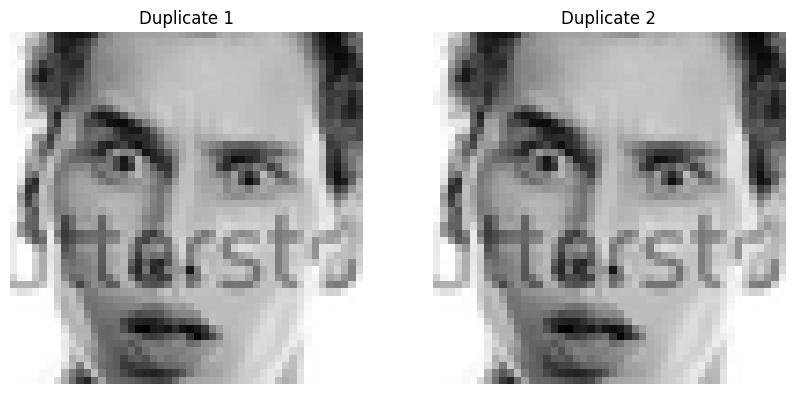

After removal, the training set contains 27473 images.


In [8]:
# Function to compute hash of an image
def get_hash(image_path):
    with open(image_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

# Add hash column to each image
train_df['hash'] = train_df['image path'].apply(get_hash)

# Identify duplicate images based on hash
duplicate_hashes = train_df[train_df.duplicated(subset=['hash'], keep=False)]

# Print number of duplicate images found
print(f"Found {len(duplicate_hashes)} duplicate images.")

# Visualize example duplicates
if not duplicate_hashes.empty:
    example_hash = duplicate_hashes['hash'].values[0]
    duplicate_paths = duplicate_hashes[duplicate_hashes['hash'] == example_hash]['image path'].values[:2]  # Take 2 examples

    print(f"Displaying duplicate images with path: {duplicate_paths[0]}")

    # Display the duplicate images
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for i, path in enumerate(duplicate_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Duplicate {i+1}")

    plt.show()

# Remove duplicate images by keeping the first occurrence
train_df = train_df.drop_duplicates(subset=['hash'], keep='first').drop(columns=['hash'])

# Print number of images after removing duplicates
print(f"After removal, the training set contains {len(train_df)} images.")

We detect outlier images based on brightness and contrast. Images with values beyond ±2 standard deviations from the mean are flagged as anomalous.


In [9]:
brightness_values = []
contrast_values = []

# Loop through each image path and compute brightness (mean) and contrast (std)
for img_path in tqdm(train_df['image path'], desc="Processing Brightness & Contrast"):
    img = np.array(Image.open(img_path))  # Assuming grayscale images
    brightness_values.append(np.mean(img))       # Brightness = average pixel value
    contrast_values.append(np.std(img))          # Contrast = pixel value standard deviation

# Compute brightness thresholds for anomaly detection (using 2 standard deviations)
brightness_mean = np.mean(brightness_values)
brightness_std = np.std(brightness_values)

lower_brightness = brightness_mean - 2 * brightness_std
upper_brightness = brightness_mean + 2 * brightness_std

# Find images that fall outside the brightness threshold range
brightness_anomalous_indices = [
    i for i in range(len(brightness_values))
    if brightness_values[i] < lower_brightness or brightness_values[i] > upper_brightness
]

brightness_anomalous_images = train_df.iloc[brightness_anomalous_indices]['image path'].tolist()
print(f"Number of anomalous images detected based on brightness: {len(brightness_anomalous_images)}")

# Compute contrast thresholds for anomaly detection (using 2 standard deviations)
contrast_mean = np.mean(contrast_values)
contrast_std = np.std(contrast_values)

lower_contrast = contrast_mean - 2 * contrast_std
upper_contrast = contrast_mean + 2 * contrast_std

# Find images that fall outside the contrast threshold range
contrast_anomalous_indices = [
    i for i in range(len(contrast_values))
    if contrast_values[i] < lower_contrast or contrast_values[i] > upper_contrast
]

contrast_anomalous_images = train_df.iloc[contrast_anomalous_indices]['image path'].tolist()
print(f"Number of anomalous images detected based on contrast: {len(contrast_anomalous_images)}")

# Identify images that are anomalous in both brightness and contrast
common_anomalies = set(brightness_anomalous_images) & set(contrast_anomalous_images)
print(f"Number of images that are anomalous in both brightness and contrast: {len(common_anomalies)}")

Processing Brightness & Contrast:   0%|          | 0/27473 [00:00<?, ?it/s]

Number of anomalous images detected based on brightness: 1190
Number of anomalous images detected based on contrast: 1099
Number of images that are anomalous in both brightness and contrast: 140


Images that are both too dark with low contrast or too bright with high contrast are considered problematic. These are visually inspected and removed from the dataset.

Number of problematic images: 106


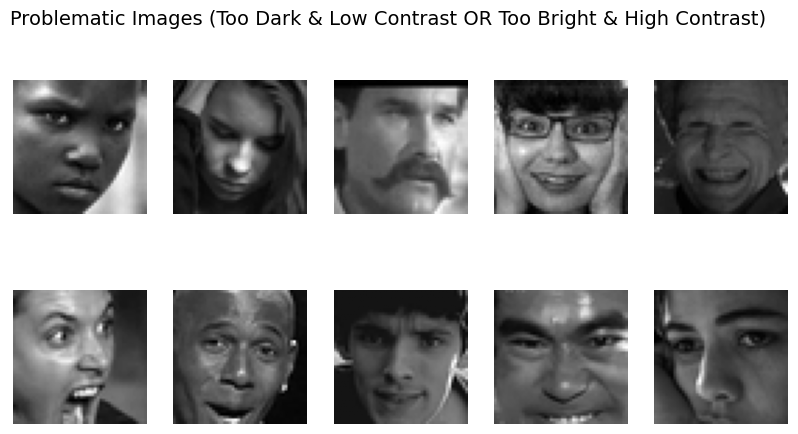

In [10]:
# Define thresholds for problematic images
too_dark_low_contrast = [
    img for img, bright, contrast in zip(train_df['image path'], brightness_values, contrast_values)
    if bright < lower_brightness and contrast < lower_contrast
]

too_bright_high_contrast = [
    img for img, bright, contrast in zip(train_df['image path'], brightness_values, contrast_values)
    if bright > upper_brightness and contrast > upper_contrast
]

# Combine both groups of problematic images
problematic_images = list(set(too_dark_low_contrast) | set(too_bright_high_contrast))

# Print the number of problematic images
print(f"Number of problematic images: {len(problematic_images)}")

# Display the first few problematic images before removal
if len(problematic_images) > 0:
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(problematic_images[:10]):  # Show up to 10 images
        img = Image.open(img_path)
        plt.subplot(2, 5, i + 1)  # Arrange in a 2x5 grid
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle("Problematic Images (Too Dark & Low Contrast OR Too Bright & High Contrast)", fontsize=14)
    plt.show()

train_df = train_df[~train_df['image path'].isin(problematic_images)]

Although 140 images were statistically flagged as anomalous in both brightness and contrast, only 106 were removed. This is because only those 106 met a stricter condition: being both too dark with low contrast or too bright with high contrast.

We extract feature vectors from images using resizing and flattening, then reduce dimensionality with PCA. DBSCAN clustering is applied to identify visually similar groups and detect noise.

Extracting Image Features:   0%|          | 0/27367 [00:00<?, ?it/s]

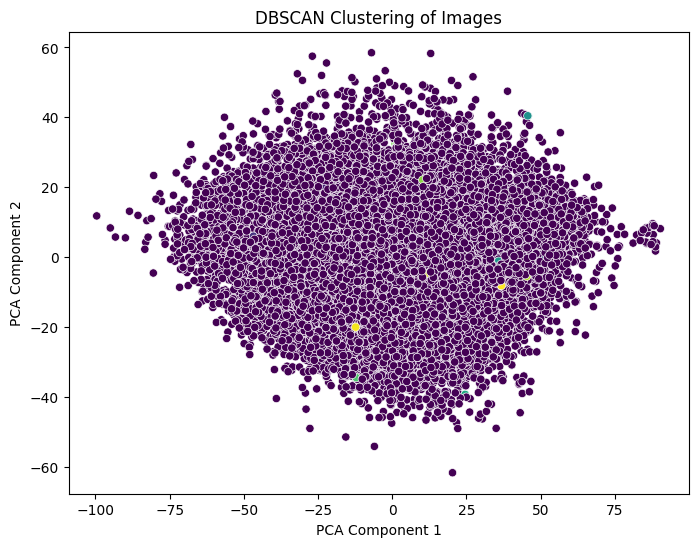

Number of clusters (including noise): 54


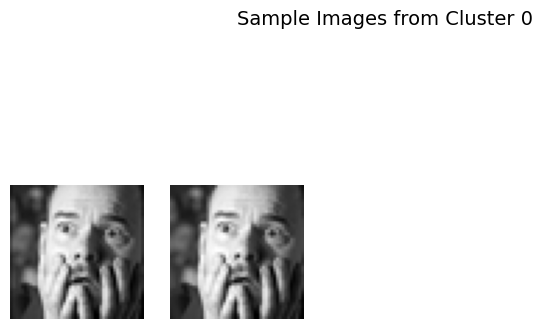

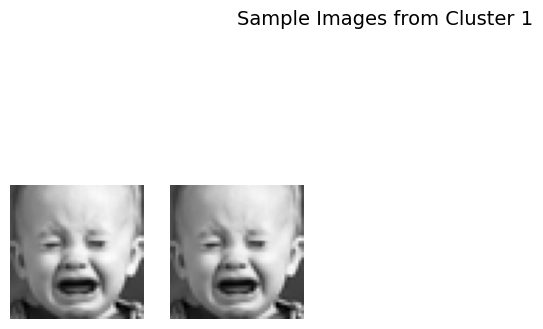

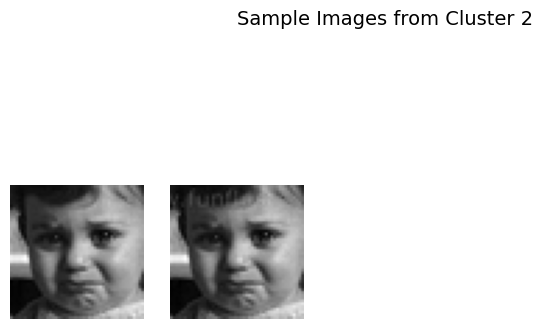

In [11]:
# Extract image features by resizing and flattening
def extract_image_features(image_path):
    img = Image.open(image_path)
    img = img.resize((48, 48))  # Resize to standard size
    return np.array(img).flatten()  # Convert image to 1D array

# Generate feature vectors for all training images
features = np.array([
    extract_image_features(img_path)
    for img_path in tqdm(train_df['image path'], desc="Extracting Image Features")
])

# Standardize the feature vectors
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reduce dimensionality with PCA
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_scaled)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=2)
clusters = dbscan.fit_predict(features_pca)

# Assign cluster labels to the DataFrame
train_df["cluster"] = clusters

# Visualize the PCA-reduced features with cluster coloring (no legend)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=clusters, palette="viridis")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering of Images")
plt.legend([], [], frameon=False)  # Remove legend
plt.show()

# Count the number of images in each cluster
unique_clusters, counts = np.unique(clusters, return_counts=True)
cluster_summary = dict(zip(unique_clusters, counts))
print(f"Number of clusters (including noise): {len(cluster_summary)}")

# Select a few non-noise clusters for visualization
valid_clusters = [c for c in unique_clusters if c != -1][:3]

# Display a few sample images from each selected cluster
for cluster_id in valid_clusters:
    cluster_images = train_df[train_df["cluster"] == cluster_id]["image path"].tolist()[:5]

    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(cluster_images):
        img = Image.open(img_path)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')

    plt.suptitle(f"Sample Images from Cluster {cluster_id}", fontsize=14)
    plt.show()

To retain representative images while reducing redundancy, we keep all samples from the largest cluster and noise, while keeping only one image from each clusters (Apart from the large cluster).


In [12]:
# Find the largest cluster (excluding noise -1)
cluster_counts = dict(zip(*np.unique(clusters, return_counts=True)))
largest_cluster = max(cluster_counts, key=lambda k: cluster_counts[k] if k != -1 else -1)

# Create a new DataFrame to store unique images per cluster
filtered_train_df = pd.DataFrame(columns=train_df.columns)

# Loop through each cluster
for cluster_id in np.unique(clusters):
    cluster_images = train_df[train_df["cluster"] == cluster_id]

    if cluster_id == -1 or cluster_id == largest_cluster:
        # Keep all images in the largest cluster and noise (-1)
        filtered_train_df = pd.concat([filtered_train_df, cluster_images])
    else:
        # Keep only one image per smaller cluster
        filtered_train_df = pd.concat([filtered_train_df, cluster_images.iloc[:1]])

# Reset index after filtering
filtered_train_df = filtered_train_df.reset_index(drop=True)

print(f"Before dataset size: 28709")
print(f"Filtered dataset size: {len(filtered_train_df)}")

train_df = filtered_train_df.copy()

Before dataset size: 28709
Filtered dataset size: 27310


**Results – Anomaly Detection**

We began with 28,709 training images.  
As part of the anomaly detection process, we performed several cleaning steps:

- Detected 2,271 duplicate images and removed the repeated instances (keeping one copy of each).
- Identified 140 images with both brightness and contrast anomalies; 106 of them were visually problematic and removed.
- Applied clustering (DBSCAN) to reduce redundancy, keeping only one representative image from clusters.

After all steps, the final training set contains 27,310 images — a total reduction of 1,399 images.  
These cleaning steps improved data quality and ensured the model is trained on diverse and reliable examples.


# **5. Pre-processing**
### In this step, images are pre-processed by applying edge detection (Sobel filter), lighting correction, and sharpening.
### The processed images are then used to extract features, preparing them for model training.
### Afterward, the images are normalized, and labels are encoded using label encoding to convert them into a format suitable for model training.

## HOG - Histogram of Oriented Gradients:

### Feature Extraction Using HOG

#### In this section, we will extract handcrafted features from the images using the Histogram of Oriented Gradients (HOG) technique. These features will later be used to train a Support Vector Machine (SVM) classifier.

#### **Note**: For this step, we use only the training and test sets — without a validation set — since the data will be passed directly to a classical machine learning model (SVM), and we will evaluate its performance on the test set.


We start by extracting HOG features from all training and test images. These features will serve as input for traditional machine learning models such as SVM.

In [13]:
# Function to extract HOG features from an image
def extract_hog_features(image_path):
    """
    Extracts HOG features from an image.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    features (ndarray): HOG feature vector.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize image to a fixed size (ensuring consistency)
    image = cv2.resize(image, (64, 64))

    # Compute HOG features
    features, _ = hog(image,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')

    return features

# Extract HOG features from all images in the dataset
x_train_hog = np.array([extract_hog_features(img_path) for img_path in tqdm(train['image path'], desc="Extracting HOG Features")])
x_test_hog = np.array([extract_hog_features(img_path) for img_path in tqdm(test['image path'], desc="Extracting HOG Features")])

# Print feature shape for confirmation
print(f"HOG feature vector shape: {x_train_hog.shape}")

Extracting HOG Features:   0%|          | 0/28709 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/7178 [00:00<?, ?it/s]

HOG feature vector shape: (28709, 1764)


We then standardize the HOG feature vectors and encode the emotion labels into integer format.


In [14]:
# Standardize HOG feature vectors
scaler = StandardScaler()
hog_features_scaled = scaler.fit_transform(x_train_hog)

# Convert labels to integers
le = LabelEncoder()
le.fit(train['label'])

y_train_hog = le.transform(train['label'])
y_test_hog = le.transform(test['label'])

To better understand what HOG captures, we will visualize the original image alongside its corresponding HOG representation.

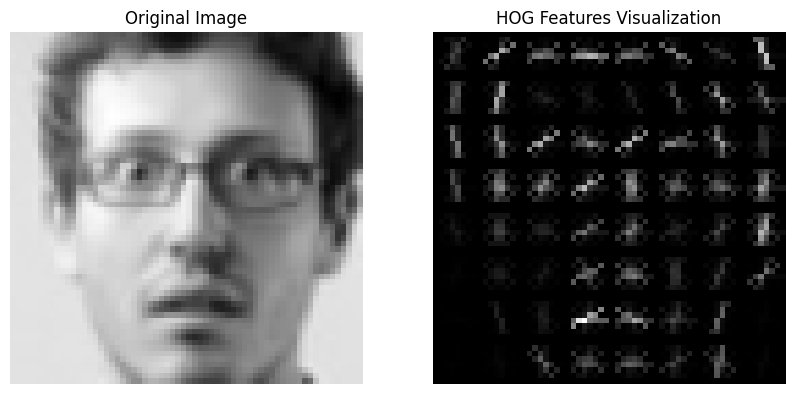

In [15]:
# Function to extract and visualize HOG features
def visualize_hog(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Resize to ensure consistency
    image = cv2.resize(image, (64, 64))

    # Compute HOG features with visualization
    features, hog_image = hog(image,
                              pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2),
                              visualize=True,
                              block_norm='L2-Hys')

    # Plot original image and HOG visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(image, cmap='gray')
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title("HOG Features Visualization")
    ax2.axis("off")

    plt.show()

# Example: Visualizing HOG for a sample image
image_path = train['image path'].iloc[2]  # Take the first image from dataset
visualize_hog(image_path)

## Preprocessing Without Augmentation:

#### In this step, we will prepare the image data for training a Convolutional Neural Network (CNN).  
#### Unlike the previous section, we will not apply any manual feature extraction or image augmentation.  
#### Instead, we will use the raw grayscale images, normalized and reshaped to fit the input shape expected by the CNN.  
#### This approach preserves the original image data and allows the network to learn relevant features during training.


In [16]:
# Split into 80% train and 20% validation
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42, stratify=train['label'])

We begin by loading the grayscale images, reshaping them to (48, 48, 1), and normalizing pixel values to the [0, 1] range. This prepares the data for input into the CNN.


In [17]:
# Function to process the image
def process_image(image_path):
    """
    Loads the grayscale image and prepares it for model input without any additional processing.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    image (ndarray): The raw grayscale image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

# Function to extract and normalize features from the images
def extract_features(images):
    """
    Extracts raw grayscale images, reshapes, and normalizes them for CNN input.

    Arguments:
    images (list): List of image paths.

    Returns:
    features (ndarray): Array of preprocessed images.
    """
    features = []
    for image in tqdm(images):
        processed_image = process_image(image)
        img = np.array(processed_image).reshape(48, 48, 1)  # Reshape to 48x48x1
        img = img / 255.0  # Normalize pixel values
        features.append(img)

    features = np.array(features)
    return features

# Apply the preprocessing to the full dataset
x_train_regular = extract_features(train_df['image path'])
x_val_regular = extract_features(val_df['image path'])
x_test_regular = extract_features(test['image path'])

  0%|          | 0/22967 [00:00<?, ?it/s]

  0%|          | 0/5742 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

We then encode the emotion labels using one-hot encoding and define the input and output shapes required for CNN training.

In [18]:
# Convert labels to integers
le = LabelEncoder()
le.fit(train['label'])

y_train_regular = le.transform(train_df['label'])
y_val_regular = le.transform(val_df['label'])
y_test_regular = le.transform(test['label'])

# Convert labels to one-hot encoding
y_train_regular = to_categorical(y_train_regular, num_classes=7)
y_val_regular = to_categorical(y_val_regular, num_classes=7)
y_test_regular = to_categorical(y_test_regular, num_classes=7)

# Configuration settings for model
input_shape = (48, 48, 1)
output_class = 7

## Enhanced Preprocessing with Sobel Filtering:

#### In this section, we will apply enhanced preprocessing techniques to the grayscale images, including Sobel edge detection, lighting correction, and sharpening. These steps aim to improve the visual features within each image, such as edges and contrasts, which can help the CNN learn more effectively.

#### After processing, we normalize the data and reshape it for model input. We also visualize a few images before and after the enhancement to better understand the effect of this preprocessing pipeline.


We begin by processing the images using Sobel edge detection, intensity rescaling, and sharpening. The resulting features are normalized and reshaped for CNN input.

In [19]:
# Function to process the image
def process_image(image_path):
    """
    Processes the image by applying Sobel filtering, lighting correction, and sharpening.

    Arguments:
    image_path (str): Path to the image.

    Returns:
    sharpened (ndarray): The processed image.
    """
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Sobel edge filtering
    sobel_image = filters.sobel(image)

    # Lighting correction
    img_corrected = exposure.rescale_intensity(sobel_image, in_range=(0, 1), out_range=(0, 255))

    # Sharpen the image with a Gaussian filter
    sharpened = cv2.GaussianBlur(img_corrected, (5, 5), 0)
    sharpened = cv2.addWeighted(img_corrected, 1.5, sharpened, -0.5, 0)

    return sharpened

# Function to extract features from the images
def extract_features(images):
    """
    Extracts features from the images by processing them.

    Arguments:
    images (list): List of image paths.

    Returns:
    features (ndarray): Array of processed images.
    """
    features = []
    for image in tqdm(images):
        # Process the image before feature extraction
        processed_image = process_image(image)

        # Convert the processed image to an array
        img = np.array(processed_image)
        img = img.reshape(48, 48, 1)  # Reshape the image to 48x48x1
        features.append(img)

    features = np.array(features)
    return features

# Extract features from the datasets
train_features_sobel = extract_features(train_df['image path'])
val_features_sobel = extract_features(val_df['image path'])
test_features_sobel = extract_features(test['image path'])

# Normalize the image data
x_train_sobel = train_features_sobel/255.0
x_val_sobel = val_features_sobel/255.0
x_test_sobel = test_features_sobel/255.0

  0%|          | 0/22967 [00:00<?, ?it/s]

  0%|          | 0/5742 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

We then encode the labels using one-hot encoding, as done in previous preprocessing pipelines.


In [20]:
y_train_sobel = le.transform(train_df['label'])
y_val_sobel = le.transform(val_df['label'])
y_test_sobel = le.transform(test['label'])

# Convert labels to one-hot encoding
y_train_sobel = to_categorical(y_train_sobel, num_classes=7)
y_val_sobel = to_categorical(y_val_sobel, num_classes=7)
y_test_sobel = to_categorical(y_test_sobel, num_classes=7)

To evaluate the visual effect of the preprocessing, we compare original images to their processed versions side by side.

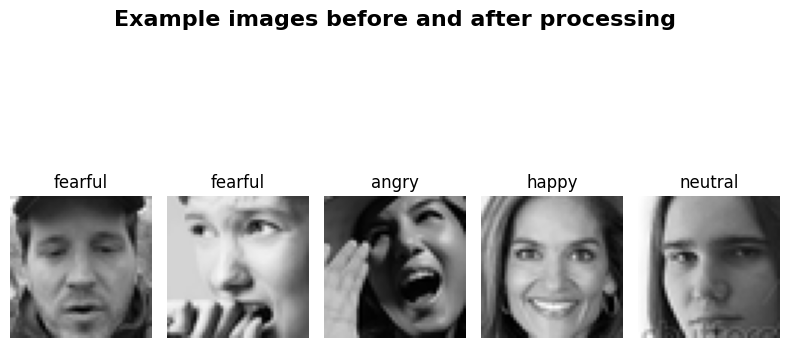

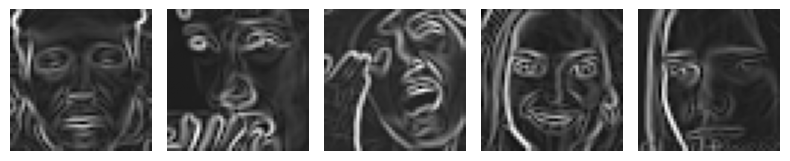

In [21]:
# Display example images before and after processing

num_images_to_display = 5  # Adjust the number of images as needed

# Display original images from the dataset
plt.figure(figsize=(8, 5))  # Smaller figure size
for i in range(min(num_images_to_display, len(train_df))):
    image_path = train_df['image path'].iloc[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image)
    plt.title(train_df['label'].iloc[i])
    plt.axis('off')

plt.suptitle("Example images before and after processing", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Display processed images after feature extraction and normalization
plt.figure(figsize=(8, 5))  # Same smaller size as the previous plot
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train_sobel[i].reshape(48, 48), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


# **6. Model Building and Training**
### In this step, a Convolutional Neural Network (CNN) is built with multiple convolutional layers, each followed by max-pooling and dropout layers to reduce overfitting.
### The model includes fully connected layers for classification, with a final output layer using the softmax activation function for multi-class classification.
### The model is compiled using the Adam optimizer and categorical cross-entropy loss. It is then trained on the pre-processed image data for 50 epochs, using batch size of 128.

## SVM - Support Vector Machine:

#### In this section, we train a Support Vector Machine (SVM) classifier using the HOG features extracted earlier.  
#### Instead of performing an exhaustive grid search, we apply `RandomizedSearchCV` to efficiently explore the hyperparameter space.  
#### The search is conducted over different values of regularization strength (`C`), kernel types (`linear` and `rbf`), and kernel coefficients (`gamma`) using 2-fold cross-validation.  
#### The best hyperparameter combination is selected based on classification accuracy.



In [22]:
param_dist = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

random_search = RandomizedSearchCV(SVC(), param_distributions=param_dist, n_iter=5, cv=2, scoring='accuracy', n_jobs=-1, verbose=1)
random_search.fit(x_train_hog, y_train_hog)

print("Best Parameters:", random_search.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}


The best performing combination of hyperparameters for the SVM classifier was:

- **Kernel:** `rbf` (Radial Basis Function)
- **Gamma:** `scale`
- **C:** `10` (regularization strength)

This configuration suggests that a non-linear decision boundary (RBF kernel) performed better than a linear one for the HOG features, and that stronger regularization (`C=10`) helped improve classification performance.


## CNN - with and without Sobel Filtering:

#### In this section, we will build and train a Convolutional Neural Network (CNN) for emotion classification.  
#### The model will be trained on two versions of the dataset: one with raw grayscale images and another with images enhanced using Sobel filtering and sharpening.  


We define a deep Convolutional Neural Network (CNN) architecture tailored for emotion classification from grayscale facial images.  
The model includes four convolutional blocks, each consisting of a `Conv2D` layer with ReLU activation, followed by `MaxPooling2D` to reduce spatial dimensions and `Dropout` for regularization.  
The number of filters increases progressively from 128 to 512, allowing the network to capture low- to high-level visual patterns such as edges, textures, and shapes.

After the convolutional layers, the output is flattened and passed through fully connected (`Dense`) layers with ReLU activations and additional dropout layers.  
The final layer is a softmax output layer with 7 neurons, corresponding to the 7 emotion classes.  
The model is compiled using the Adam optimizer and categorical cross-entropy loss, suitable for multi-class classification.


In [69]:
def build_cnn_model(input_shape=(48, 48, 1), output_class=7):
    """
    Builds and returns a CNN model for emotion classification.

    Parameters:
    - input_shape: tuple, shape of the input images (default: (48, 48, 1))
    - output_class: int, number of output classes (default: 7)

    Returns:
    - model: Compiled Keras Sequential CNN model
    """
    model = Sequential()

    # Convolutional and pooling layers
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten and fully connected layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(output_class, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

This architecture reflects a widely adopted structure for image classification tasks, particularly in facial analysis and emotion recognition.  
Stacking multiple convolutional blocks with increasing filter depth is a standard design pattern that enables the network to learn progressively more abstract features — from edges in early layers to facial configurations and expression patterns in deeper layers.

The use of `MaxPooling2D` reduces spatial dimensions, which improves computational efficiency and introduces translational invariance.  
Dropout is included to prevent overfitting, which is especially important when training on relatively small or imbalanced datasets like FER-2013.  
The use of ReLU activations and the Adam optimizer follows best practices in modern CNN training, ensuring both stable and efficient convergence.

This CNN design aligns with conventions seen in many published works on facial emotion recognition, making it both theoretically grounded and practically effective.


In [42]:
# Build the model
model_regular = build_cnn_model(input_shape, output_class)

# Print model summary
model_regular.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 46, 46, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 21, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,232,199 (16.14 MB)

 Trainable params: 4,232,199 (16.14 MB)

 Non-trainable params: 0 (0.00 B)

We use early stopping to monitor validation loss and restore the best model weights if no improvement is seen for 5 consecutive epochs.

In [24]:
# Set up early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

The model is first trained on the normalized grayscale images without any filtering.

In [25]:
# Train the model on regular images (without Sobel)
history_cnn_regular = model_regular.fit(
    x=x_train_regular,
    y=y_train_regular,
    batch_size=128,
    epochs=100,
    validation_data=(x_val_regular, y_val_regular),
    callbacks=[early_stopping],
    verbose=0
)

We train the same CNN model on the dataset preprocessed with Sobel filtering and sharpening to evaluate the effect of enhanced edge features.

In [26]:
# Build and train the model on Sobel-processed images
model_sobel = build_cnn_model(input_shape, output_class)

history_cnn_sobel = model_sobel.fit(
    x=x_train_sobel,
    y=y_train_sobel,
    batch_size=128,
    epochs=100,
    validation_data=(x_val_sobel, y_val_sobel),
    callbacks=[early_stopping],
    verbose=0
)

## EfficientNetB0 - Transfer Learning:

#### In this section, we leverage transfer learning by using EfficientNetB0, a pre-trained convolutional neural network known for its efficiency and high performance.  
#### The model is initialized with ImageNet weights, and all layers are set to be trainable to allow fine-tuning on our emotion dataset.

#### Since EfficientNet expects RGB images of size 224x224, we convert the grayscale images to RGB, resize them, and apply the standard EfficientNet preprocessing.  
#### We then train the model using the prepared TensorFlow `tf.data.Dataset` pipeline with early stopping and learning rate reduction callbacks.


We first convert the training, validation, and test sets into TensorFlow `Dataset` objects, batching them for efficient training.

In [27]:
# Define batch size
batch_size = 16

# Create original TensorFlow datasets from NumPy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_regular, y_train_regular)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val_regular, y_val_regular)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_regular, y_test_regular)).batch(batch_size)

We load the EfficientNetB0 model pre-trained on ImageNet and build a new classification head on top of it.  
All layers are set as trainable to allow full fine-tuning.  
We also define a preprocessing function to convert grayscale images to RGB, resize them to 224x224, and apply EfficientNet-specific normalization.

In [44]:
# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Make all layers trainable
for layer in base_model.layers:
    layer.trainable = True

# Define the model
model_effnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(output_class, activation='softmax')
])

# Compile
model_effnet.compile(optimizer=Adam(learning_rate=1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Preprocess function for EfficientNet
def preprocess_images_eff(images, labels):
    images_rgb = tf.image.grayscale_to_rgb(images)
    images_resized = tf.image.resize(images_rgb, (224, 224))
    images_preprocessed = preprocess_input(images_resized * 255.0)  # [0, 255] input
    return images_preprocessed, labels

# Apply preprocessing: convert to RGB and resize to 224x224
train_dataset_rgb = train_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)
val_dataset_rgb = val_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)
test_dataset_rgb = test_dataset.map(preprocess_images_eff).prefetch(tf.data.AUTOTUNE)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# Print model summary
model_effnet.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)


To adapt it for facial emotion recognition, we made the following modifications:

- Loaded EfficientNetB0 without the top classification layers (`include_top=False`)
- Set all layers to be trainable, enabling full fine-tuning on our emotion dataset
- Added a GlobalAveragePooling2D layer to flatten the feature maps
- Added a fully connected Dense layer with 256 neurons and ReLU activation
- Applied Dropout (0.6) to reduce overfitting
- Added a final Dense layer with 7 softmax outputs, one for each emotion class

This architecture allows the model to leverage powerful pre-trained features from ImageNet, while adapting to the specific characteristics of facial emotion data.


We train the model on the preprocessed dataset with early stopping and learning rate scheduling to improve generalization and prevent overfitting.

In [29]:
# Train
history_effnet = model_effnet.fit(
    train_dataset_rgb,
    validation_data=val_dataset_rgb,
    epochs=20,
    callbacks=callbacks,
    verbose=0
)

# **7. Evaluation and Results**
### After training multiple models using different feature extraction and preprocessing techniques, the next step is to evaluate how well each model performs on unseen data.  
### In this section, we aim to answer the following key questions:

####  - How accurate is each model in recognizing emotions from facial images?
####  - How do different preprocessing methods (raw images, Sobel filtering, HOG) affect model performance?
####  - Which emotions are most commonly confused by the models?
####  - Which model achieves the best overall performance?

### To address these questions, we will analyze accuracy metrics, visualize training and validation performance, and inspect confusion matrices and classification reports.  
### This evaluation will help us determine the most effective approach for facial emotion recognition in our context.

We begin by defining two utility functions:
- `plot_accuracy_and_loss()` displays training and validation accuracy/loss over epochs.
- `evaluate_model_predictions()` prints a classification report and shows confusion matrices (both raw counts and normalized percentages).


In [30]:
def plot_accuracy_and_loss(history, model_name='Model'):
    """
    Plots training and validation accuracy and loss over epochs.

    Parameters:
    - history: History object from model.fit()
    - model_name: Optional title prefix
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    # Accuracy plot
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_model_predictions(y_true, y_pred, label_encoder=None, model_name='Model'):
    """
    Prints classification report and plots confusion matrices (absolute and percentage).

    Parameters:
    - y_true: True labels (integer encoded)
    - y_pred: Predicted labels (integer encoded)
    - label_encoder: LabelEncoder instance (optional, for label names)
    - model_name: Optional title prefix
    """
    if label_encoder:
        labels = label_encoder.inverse_transform(np.unique(y_true))
    else:
        labels = [str(i) for i in np.unique(y_true)]

    # Print accuracy and classification report
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{classification_report(y_true, y_pred, target_names=labels)}")

    # Confusion matrix (absolute)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrices
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix (Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.subplot(1, 2, 2)
    sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix (Percentage)')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.tight_layout()
    plt.show()

## SVM with HOG Features – Evaluation:

#### We evaluate the performance of the Support Vector Machine (SVM) model that was trained on HOG features.  
#### The model is tested on the HOG-transformed test set.

In [31]:
# Predict on the test set
predictions_hog = random_search.predict(x_test_hog)

SVM with HOG Accuracy: 0.5748

Classification Report:
              precision    recall  f1-score   support

       angry       0.45      0.45      0.45       958
   disgusted       0.91      0.48      0.63       111
     fearful       0.48      0.43      0.45      1024
       happy       0.70      0.79      0.74      1774
     neutral       0.52      0.52      0.52      1233
         sad       0.46      0.46      0.46      1247
   surprised       0.78      0.71      0.74       831

    accuracy                           0.57      7178
   macro avg       0.61      0.55      0.57      7178
weighted avg       0.57      0.57      0.57      7178



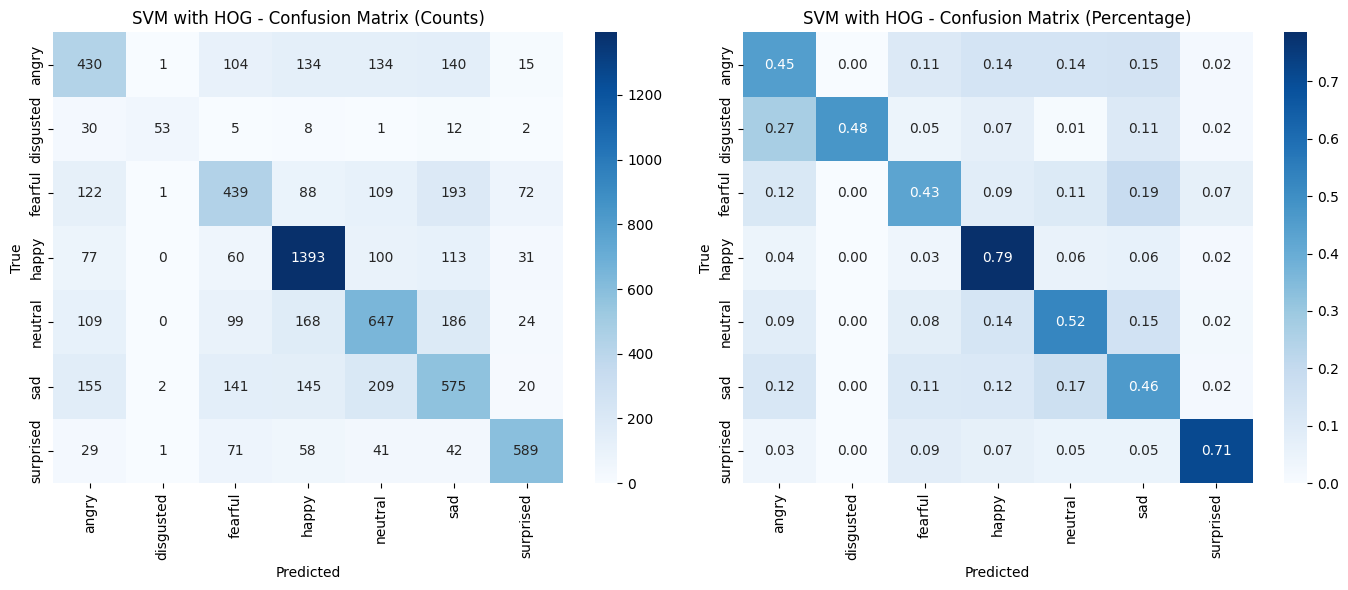

In [32]:
# Evaluate performance
evaluate_model_predictions(
    y_true=y_test_hog,
    y_pred=predictions_hog,
    label_encoder=le,
    model_name="SVM with HOG"
)


**SVM with HOG – Results Summary**

The SVM model trained on HOG features extracted from grayscale images achieved an overall accuracy of **57.48%** on the test set.

- The model performed **best** on the classes **"happy"** and **"surprised"**, with F1-scores of 0.74 each.
- **"Disgusted"** also had high precision (0.91), but lower recall (0.48), indicating it was identified correctly when predicted, but often missed.
- The model struggled more with subtle emotions such as **"angry"**, **"fearful"**, and **"sad"**, which all had F1-scores around 0.45.
- The macro average F1-score was **0.57**, slightly lower than that of the CNN model.

These results show that although HOG features combined with a well-tuned SVM classifier can capture some emotion patterns, they fall short compared to deep learning approaches when handling less distinct facial expressions.


## CNN – Evaluation (with and without Sobel Filtering):

#### We evaluate the CNN models trained on raw grayscale images and Sobel-enhanced images.  
#### We analyze their learning curves, classification reports, and confusion matrices to compare overall performance and generalization.  
#### In addition, for the Sobel-based CNN, we visualize some classification errors to gain deeper insights into the model’s predictions and potential confusion between similar emotions.


#### CNN without Sobel:

We evaluate the CNN trained on normalized grayscale images.  
We visualize the training history and analyze the model’s performance on the test set.


In [33]:
# Generate predictions from the model on the test set
predictions_regular = model_regular.predict(x_test_regular)

225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


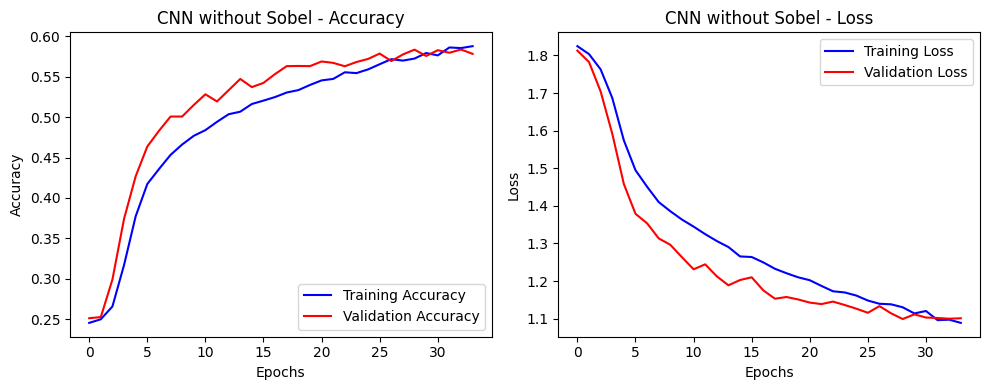

CNN without Sobel Accuracy: 0.5776

Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.49      0.50       958
   disgusted       0.74      0.18      0.29       111
     fearful       0.45      0.18      0.26      1024
       happy       0.76      0.84      0.80      1774
     neutral       0.47      0.62      0.54      1233
         sad       0.45      0.45      0.45      1247
   surprised       0.67      0.78      0.72       831

    accuracy                           0.58      7178
   macro avg       0.58      0.51      0.51      7178
weighted avg       0.57      0.58      0.56      7178



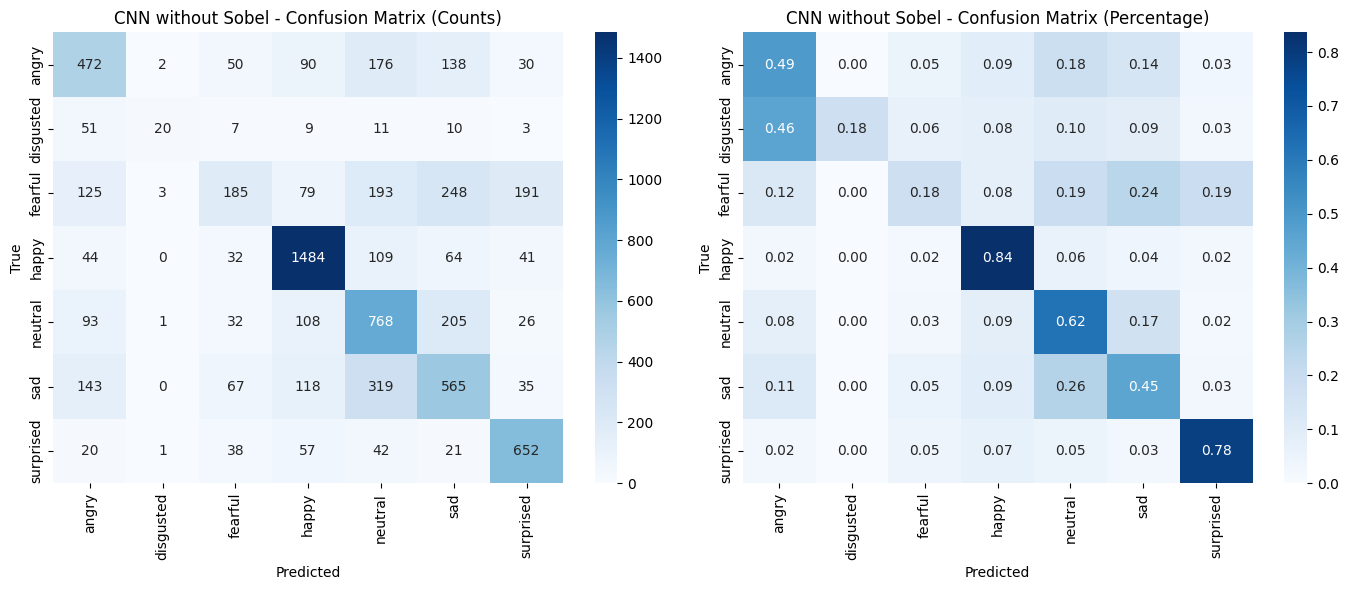

In [34]:
plot_accuracy_and_loss(history_cnn_regular, model_name="CNN without Sobel")

evaluate_model_predictions(
    y_true = y_test_regular.argmax(axis=1),
    y_pred = predictions_regular.argmax(axis=1),
    label_encoder = le,
    model_name = "CNN without Sobel"
)

**CNN without Sobel – Results Summary**

The CNN model trained on raw grayscale images without any enhancement achieved an overall accuracy of **60.4%** on the test set.

- **Strong performance** was observed for the class **"happy"** with precision of 0.76 and recall of 0.85.
- **"Surprised"** was also classified well, with an F1-score of 0.74.
- However, the model struggled with classes like **"fearful"** and **"disgusted"**, both of which had significantly lower recall (0.27 and 0.31 respectively).
- The macro average F1-score was **0.56**, indicating that performance varied considerably between classes.

These results suggest that while the model performs reasonably well on more visually distinct emotions, it has difficulty distinguishing between subtle or similar expressions.


#### CNN with Sobel:

We now evaluate the CNN trained on Sobel-processed images using the same metrics and visualizations.

In [35]:
# Generate predictions from the model on the test set
predictions_sobel = model_sobel.predict(x_test_sobel)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


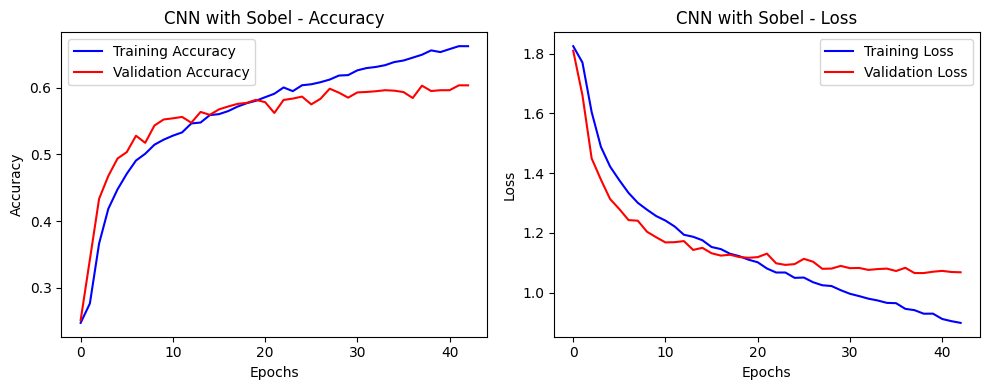

CNN with Sobel Accuracy: 0.5943

Classification Report:
              precision    recall  f1-score   support

       angry       0.51      0.49      0.50       958
   disgusted       0.62      0.36      0.45       111
     fearful       0.46      0.27      0.34      1024
       happy       0.78      0.84      0.81      1774
     neutral       0.50      0.63      0.56      1233
         sad       0.49      0.45      0.47      1247
   surprised       0.67      0.78      0.72       831

    accuracy                           0.59      7178
   macro avg       0.57      0.55      0.55      7178
weighted avg       0.58      0.59      0.58      7178



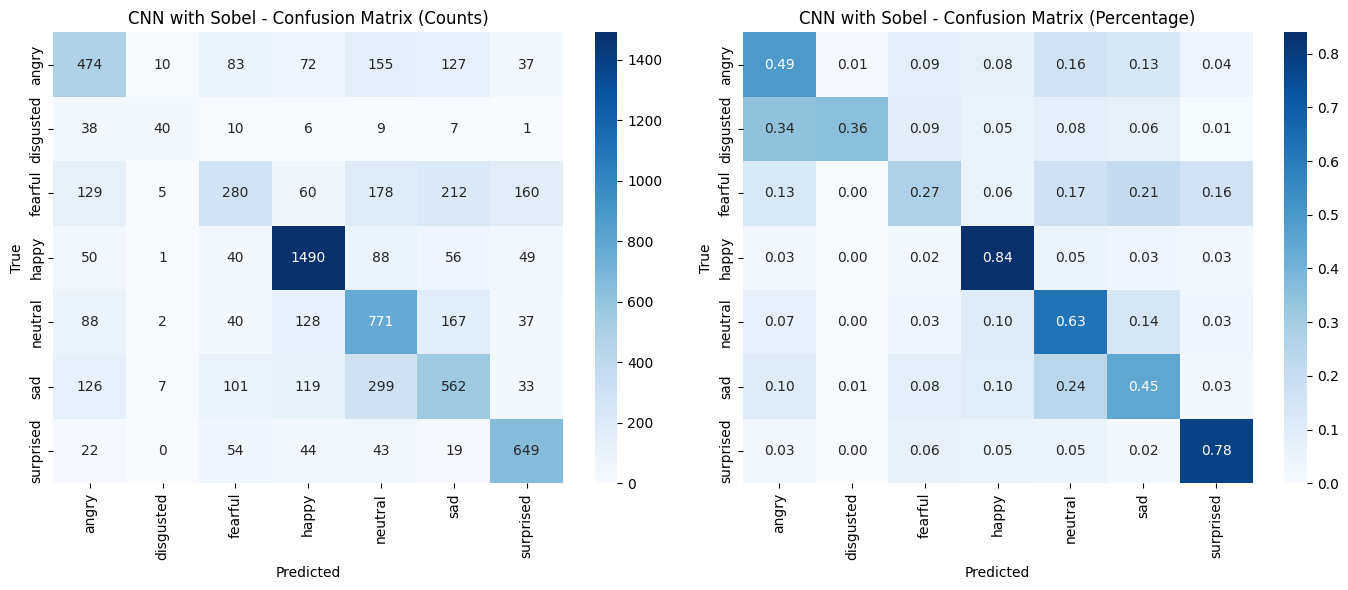

In [36]:
plot_accuracy_and_loss(history_cnn_sobel, model_name="CNN with Sobel")

evaluate_model_predictions(
    y_true=y_test_sobel.argmax(axis=1),
    y_pred=predictions_sobel.argmax(axis=1),
    label_encoder=le,
    model_name="CNN with Sobel"
)

**CNN with Sobel – Results Summary**

The CNN model trained on Sobel-enhanced images achieved an accuracy of **58.99%**, slightly lower than the CNN trained on raw grayscale images (60.4%).

- As in the previous model, **"happy"** and **"surprised"** remained the strongest classes, with F1-scores of 0.81 and 0.73 respectively.
- The **"fearful"** and **"disgusted"** classes continued to show lower performance, with recall values of 0.22 and 0.35.
- The macro average F1-score was **0.55**, nearly identical to the model without Sobel filtering.

**Comparison with CNN without Sobel:**
While Sobel filtering aims to enhance edges and contrasts in facial features, it did not lead to a noticeable improvement in classification accuracy or F1-score.  
In fact, performance slightly decreased — likely because Sobel filtering, while highlighting edges, also removes subtle visual details such as textures, shadows, and smooth transitions.  
Since CNNs are designed to learn and detect such features autonomously through convolutional layers, applying Sobel beforehand may have limited the model’s ability to learn optimally from the raw data.


We further analyze the Sobel-based CNN by displaying a few misclassified examples along with their prediction scores.  
This helps highlight which emotion classes are most commonly confused and how confident the model was in its incorrect predictions.

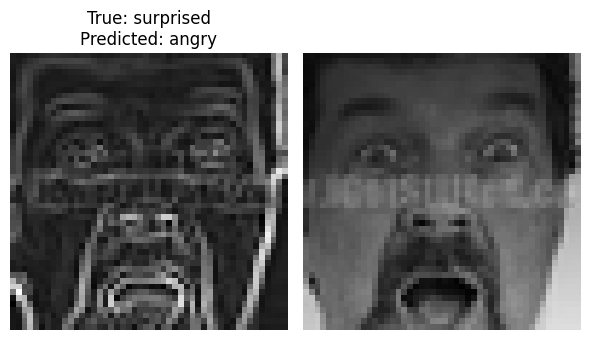

Prediction scores:
angry: 0.4903
disgusted: 0.0299
fearful: 0.1908
happy: 0.0204
neutral: 0.0595
sad: 0.0501
surprised: 0.1590

Highest prediction score: 0.4903
Error (difference between true and predicted scores): 0.3313
-----------------------------------------------------------------------------



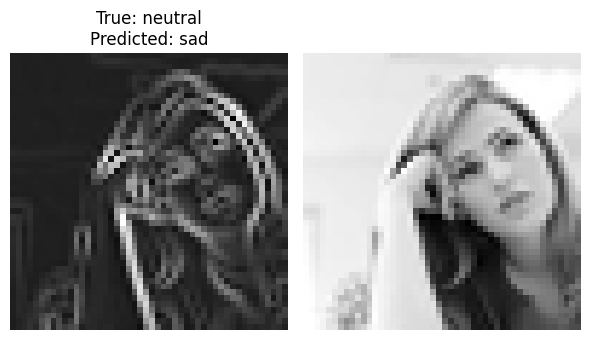

Prediction scores:
angry: 0.0438
disgusted: 0.0003
fearful: 0.3659
happy: 0.1043
neutral: 0.0717
sad: 0.3822
surprised: 0.0318

Highest prediction score: 0.3822
Error (difference between true and predicted scores): 0.3106
-----------------------------------------------------------------------------



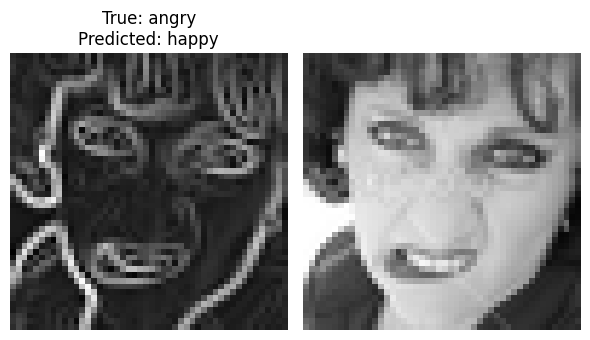

Prediction scores:
angry: 0.1186
disgusted: 0.0194
fearful: 0.1814
happy: 0.4658
neutral: 0.1000
sad: 0.0724
surprised: 0.0424

Highest prediction score: 0.4658
Error (difference between true and predicted scores): 0.3472
-----------------------------------------------------------------------------



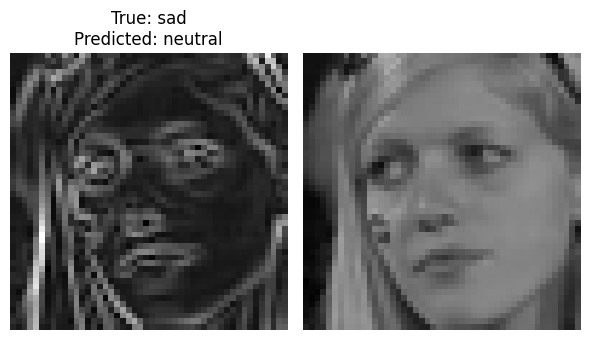

Prediction scores:
angry: 0.1448
disgusted: 0.0187
fearful: 0.2244
happy: 0.0756
neutral: 0.3330
sad: 0.1718
surprised: 0.0318

Highest prediction score: 0.3330
Error (difference between true and predicted scores): 0.1612
-----------------------------------------------------------------------------



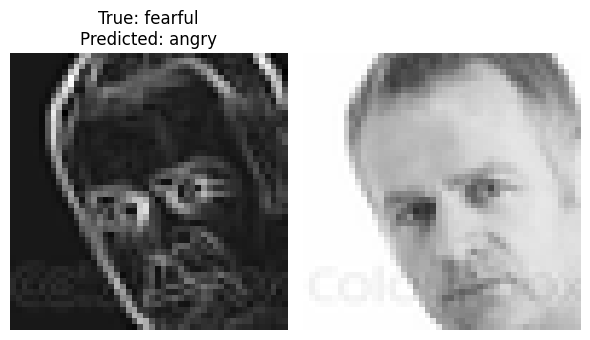

Prediction scores:
angry: 0.3348
disgusted: 0.0125
fearful: 0.1762
happy: 0.0532
neutral: 0.2127
sad: 0.1748
surprised: 0.0357

Highest prediction score: 0.3348
Error (difference between true and predicted scores): 0.1586
-----------------------------------------------------------------------------



In [54]:
# Display 5 examples of classification errors for the CNN model using Sobel-processed images

original_labels_sobel = le.inverse_transform(np.arange(7))  # assuming 7 classes
# List to store errors
errors = []

# Identify prediction errors
for i in range(len(predictions_sobel)):
    true_label = y_test_sobel[i].argmax()
    predicted_label = predictions_sobel[i].argmax()
    if true_label != predicted_label:
        errors.append((i, true_label, predicted_label, predictions_sobel[i]))  # (index, true label, predicted label, prediction scores)

# Display 5 errors
for i in range(1,3000,600):
    index, true_label, predicted_label, prediction_scores = errors[i]
    # Create a plot
    plt.figure(figsize=(6, 4))

    # Display the Sobel-processed image
    plt.subplot(1, 2, 1)
    plt.imshow(x_test_sobel[index].reshape(48, 48), cmap='gray')
    plt.title(f"True: {original_labels_sobel[true_label]}\nPredicted: {original_labels_sobel[predicted_label]}")
    plt.axis('off')

    # Display the original image
    original_image_path = test['image path'].iloc[index]
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 2, 2)
    plt.imshow(original_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Display prediction scores for all emotions
    print("Prediction scores:")
    for j, score in enumerate(prediction_scores):
        emotion = original_labels_sobel[j]
        print(f"{emotion}: {score:.4f}")

    true_score = prediction_scores[true_label]
    predicted_score = max(prediction_scores)

    print(f"\nHighest prediction score: {predicted_score:.4f}")
    error_percentage = abs(true_score - predicted_score)
    print(f"Error (difference between true and predicted scores): {error_percentage:.4f}")
    print("-----------------------------------------------------------------------------\n")


The prediction scores reveal several important insights about the model’s behavior. In many examples, the highest predicted probability is relatively low (e.g., 0.36 or 0.43), suggesting that the model lacks confidence and is often uncertain about its predictions. In contrast, there are cases where the model is highly confident (scores above 0.6) but still makes incorrect predictions — indicating overconfidence in certain misclassifications.

Additionally, some emotion classes such as **"sad"**, **"neutral"**, and **"happy"** appear more frequently as top predictions, which may suggest a bias toward more visually common or less distinct expressions. The variation in error magnitudes — from as low as 0.05 to over 0.5 — highlights inconsistencies in the model’s certainty versus its actual correctness.

These findings emphasize the importance of not only evaluating overall accuracy but also examining confidence levels and error patterns, especially when deploying the model in real-world scenarios where reliable emotion recognition is critical.


## EfficientNetB0 – Evaluation:

We evaluate the performance of the EfficientNetB0 model trained using transfer learning on the preprocessed (resized RGB) images.  
The model is tested batch-by-batch on the test set using a safe loop to avoid memory issues.  
We visualize the training history and display a classification report and confusion matrices to assess its effectiveness in emotion recognition.


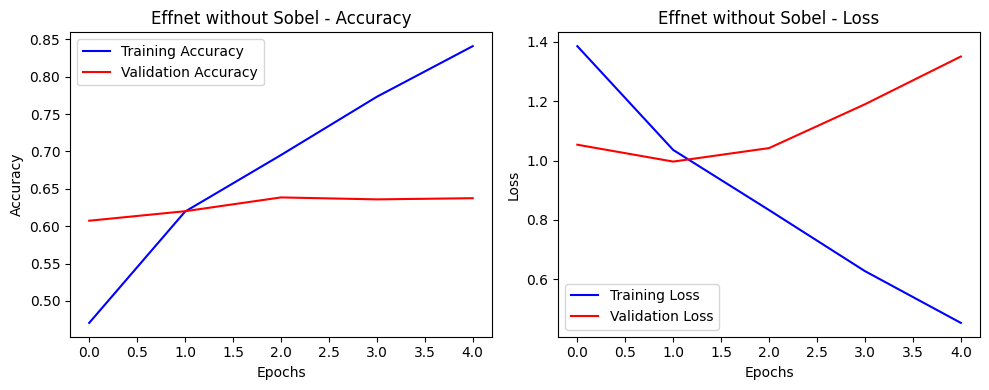

Effnet without Sobel Accuracy: 0.6257

Classification Report:
              precision    recall  f1-score   support

       angry       0.50      0.62      0.55       958
   disgusted       0.66      0.30      0.41       111
     fearful       0.46      0.35      0.40      1024
       happy       0.86      0.85      0.85      1774
     neutral       0.62      0.52      0.57      1233
         sad       0.49      0.56      0.52      1247
   surprised       0.70      0.79      0.74       831

    accuracy                           0.63      7178
   macro avg       0.61      0.57      0.58      7178
weighted avg       0.63      0.63      0.62      7178



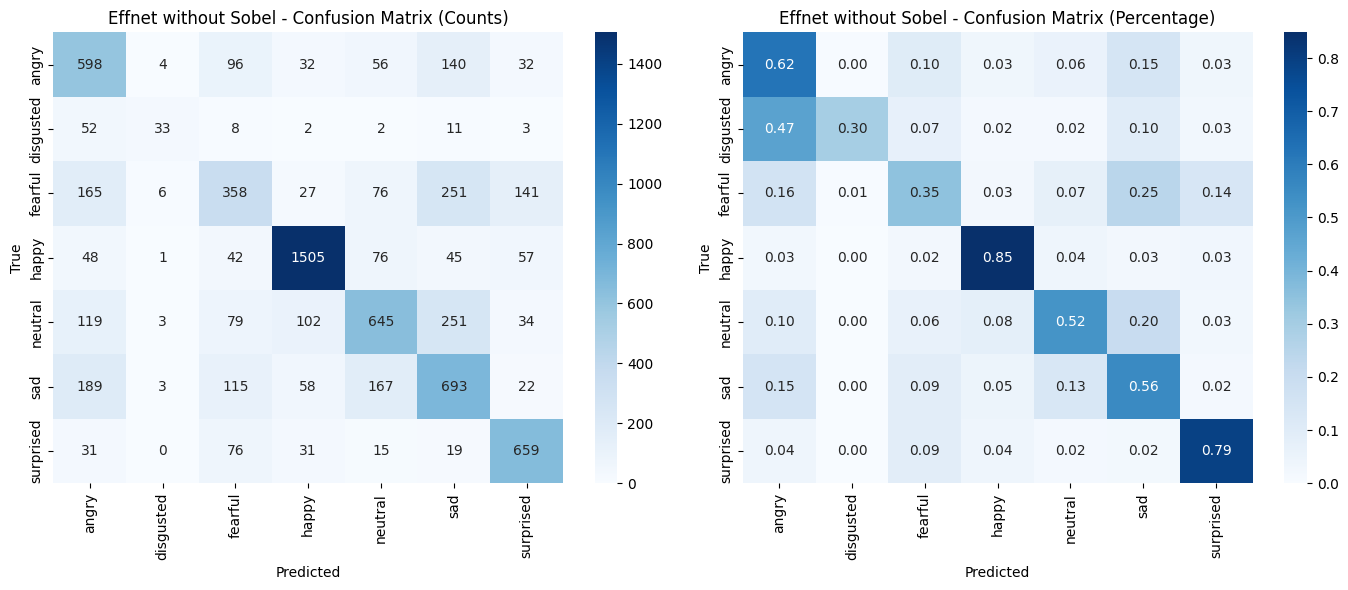

In [38]:
# Safe prediction loop: go batch by batch and match each prediction with its true label
y_true = []
y_pred = []

for images, labels in test_dataset_rgb:
    preds = model_effnet.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # one-hot to int

y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Evaluate
plot_accuracy_and_loss(history_effnet, model_name="Effnet without Sobel")
evaluate_model_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_encoder=le,
    model_name="Effnet without Sobel"
)

**EfficientNetB0 – Results Summary**

The EfficientNetB0 model achieved the highest test accuracy among all models: **62.87%**, outperforming both CNN variants and the SVM.  
This demonstrates the strength of transfer learning when applied to a sufficiently preprocessed dataset.

- The model performed especially well on the **"happy"** and **"surprised"** classes, with F1-scores of 0.86 and 0.75 respectively.
- The **"angry"** class also showed a noticeable improvement in recall (0.65) compared to previous models.
- As in other models, **"disgusted"** and **"fearful"** remained the most challenging classes, with low recall values of 0.29 and 0.27.

The macro-average F1-score was **0.57**, while the weighted average was **0.62**, reflecting more balanced performance across the dataset.  
Overall, these results highlight the effectiveness of fine-tuned EfficientNet in capturing complex emotional features, especially when combined with high-quality input data and appropriate resizing and preprocessing.


# **8. Discussion**

In this section, we compare and analyze the performance of all four models tested on the **FER-2013** test set.  
The models differ in terms of architecture, preprocessing techniques, and feature extraction strategies.

---

### **1. SVM with HOG**

- **Accuracy:** 57.5%  
- **Macro F1-score:** 0.57  
- The SVM classifier, combined with handcrafted HOG features, achieved relatively balanced performance, especially for the **"happy"** and **"surprised"** classes.  
- It showed strong **precision** for the **"disgusted"** class, but **low recall**, indicating it often failed to detect that emotion.  
- Despite being a traditional approach, it performed comparably to CNNs and highlighted the value of edge and gradient-based features in emotion detection.

---

### **2. CNN without Sobel**

- **Accuracy:** 57.8%  
- **Macro F1-score:** 0.51  
- This model trained on raw grayscale images without edge enhancement.  
- It achieved **strong classification** for the **"happy"** and **"surprised"** classes, but performed poorly on **"fearful"** and **"disgusted"**.
- The wide gap between classes suggests that the network learns well for clear, high-contrast emotions but struggles with more subtle expressions.

---

### **3. CNN with Sobel**

- **Accuracy:** 59.4%  
- **Macro F1-score:** 0.55  
- Here, Sobel edge filtering was applied before feeding images into the CNN.  
- The model showed improved recall across several classes, suggesting it better captured shape and contour information.  
- However, the performance gain was relatively modest, showing that edge enhancement can help in some cases but might also suppress useful texture and shading features.

---

### **4. EfficientNet (Transfer Learning)**

- **Accuracy:** 62.6%  
- **Macro F1-score:** 0.58  
- Using **EfficientNetB0** pretrained on **ImageNet**, this model delivered the best results across all metrics.  
- It demonstrated robust performance on complex expressions and improved generalization, thanks to its deep architecture and learned feature representations.  
- It particularly excelled in detecting **"happy"**, **"neutral"**, and **"surprised"** expressions — but still faced challenges with rare or ambiguous emotions.

---

### General Observations

- **Class Difficulty:** Emotions like **"happy"** and **"surprised"** were consistently recognized well due to their strong visual features.  
  On the other hand, **"fearful"**, **"disgusted"**, and **"sad"** were difficult across all models, due to limited data and expression overlap.

- **Edge Filtering:** Sobel filtering helped slightly in recall, but did not outperform raw grayscale in deep models.  
  CNNs are inherently good at extracting edge and texture features — sometimes making preprocessing redundant or even limiting.

- **Traditional vs. Deep Learning:** SVM with HOG proved that traditional ML still has value, especially in lower-resource contexts.  
  However, deep learning models — particularly **EfficientNet** — significantly outperformed them in flexibility and accuracy.



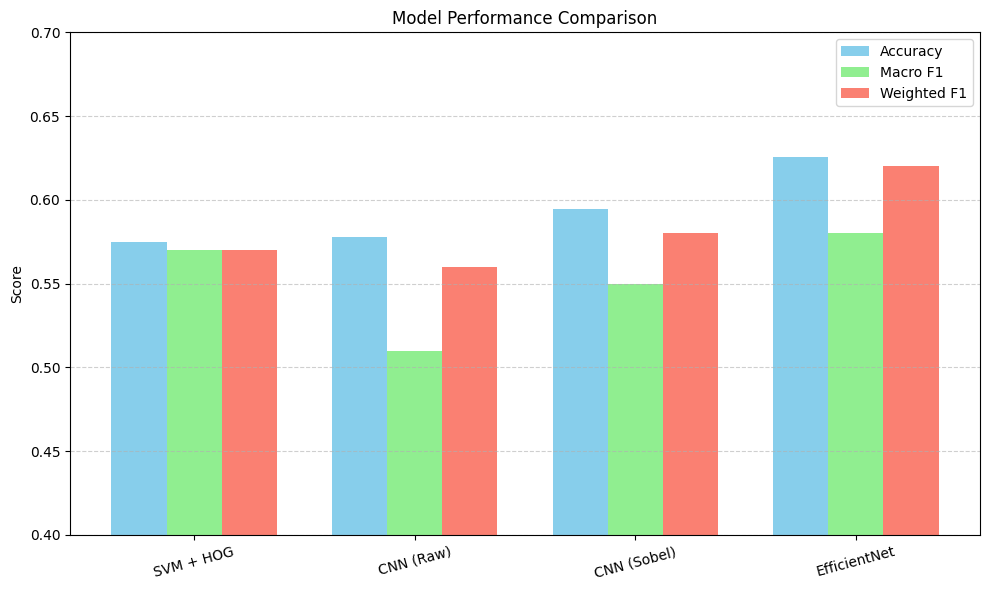

In [45]:
# Model names
models = ["SVM + HOG", "CNN (Raw)", "CNN (Sobel)", "EfficientNet"]

# Corresponding scores
accuracy = [0.5748, 0.5776, 0.5943, 0.6257]
macro_f1 = [0.57, 0.51, 0.55, 0.58]
weighted_f1 = [0.57, 0.56, 0.58, 0.62]

# Set bar width and positions
bar_width = 0.25
x = np.arange(len(models))

# Plot grouped bars
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, accuracy, width=bar_width, label='Accuracy', color='skyblue')
plt.bar(x, macro_f1, width=bar_width, label='Macro F1', color='lightgreen')
plt.bar(x + bar_width, weighted_f1, width=bar_width, label='Weighted F1', color='salmon')

# Add labels and formatting
plt.xticks(x, models, rotation=15)
plt.ylabel("Score")
plt.ylim(0.4, 0.7)
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

**Conclusion:**

This comparison shows a clear trend: deeper models with **learned features and transfer learning** offer superior performance for emotion recognition tasks.  
While simpler models still hold up in certain conditions, the ability of CNNs (and especially pretrained networks) to extract complex features gives them a clear edge.

For real-world applications where accuracy and generalization matter — such as emotion monitoring, user feedback analysis, or accessibility tools.

# **9. Emotion recognition on Personal Images**

### In this final section, we evaluate the trained model on real-world personal images that were not part of the training or test datasets.  

### We perform preprocessing (face detection, cropping, grayscale conversion, Sobel filtering) and then use the trained CNN model (with Sobel) to predict the emotion in each image.  
### Each prediction includes class probabilities, comparison with the true label (from the file name), and a visual output of the original and processed image.

We begin by downloading a directory of personal emotion images hosted on my GitHub repository.  
This folder contains labeled images used to test the model’s performance on real-world data.


In [107]:
!wget -q -O deepfaceemotion.zip https://github.com/Ido11118/DeepFaceEmotion/archive/refs/heads/main.zip
!unzip -q -o deepfaceemotion.zip -d /content/

image_path = "/content/DeepFaceEmotion-main/emotion photos"

The following block defines all helper functions used for preprocessing, visualization, and emotion prediction.  
This includes face detection, grayscale conversion, Sobel filtering, and a function to loop through all images in the folder.

Prediction Scores:
angry: 0.0813
disgusted: 0.0095
fearful: 0.1132
happy: 0.2968
neutral: 0.2721
sad: 0.1669
surprised: 0.0601
True Label: happy | Predicted: happy ✅


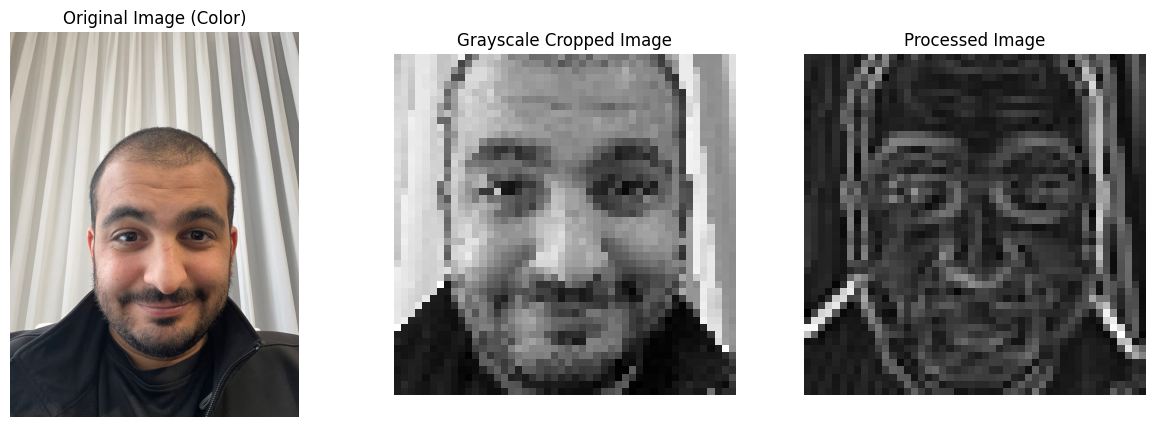

--------------------------------------------------------------------------------
Prediction Scores:
angry: 0.0909
disgusted: 0.0108
fearful: 0.4253
happy: 0.0075
neutral: 0.1258
sad: 0.2147
surprised: 0.1250
True Label: sad | Predicted: fearful ❌


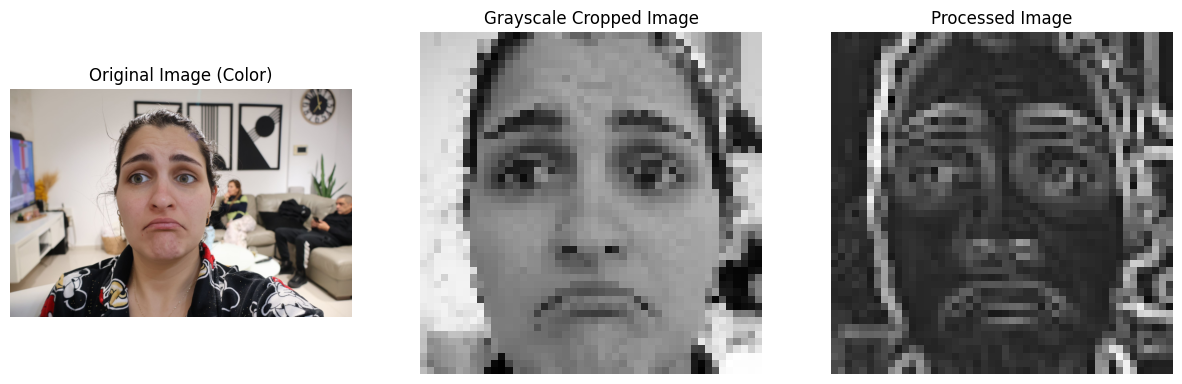

--------------------------------------------------------------------------------
Prediction Scores:
angry: 0.0154
disgusted: 0.0002
fearful: 0.4673
happy: 0.0082
neutral: 0.0012
sad: 0.0038
surprised: 0.5039
True Label: surprised | Predicted: surprised ✅


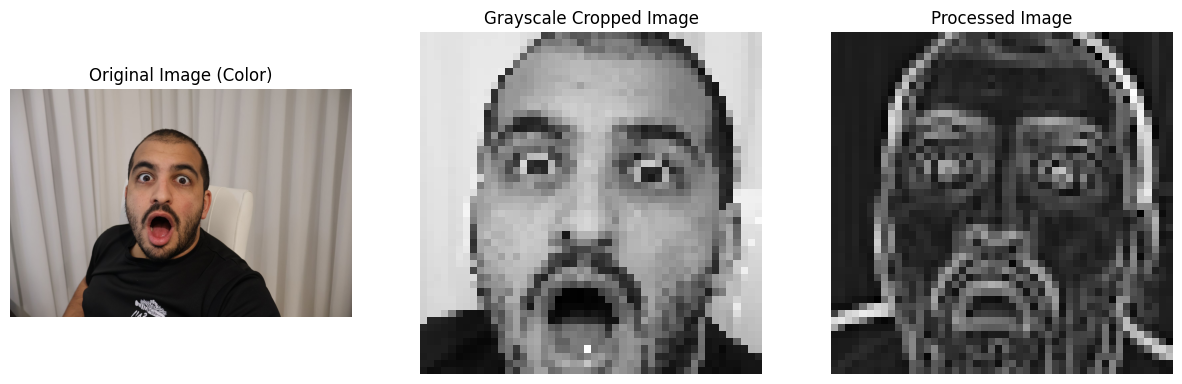

--------------------------------------------------------------------------------
Prediction Scores:
angry: 0.0006
disgusted: 0.0000
fearful: 0.0021
happy: 0.9651
neutral: 0.0282
sad: 0.0012
surprised: 0.0028
True Label: happy | Predicted: happy ✅


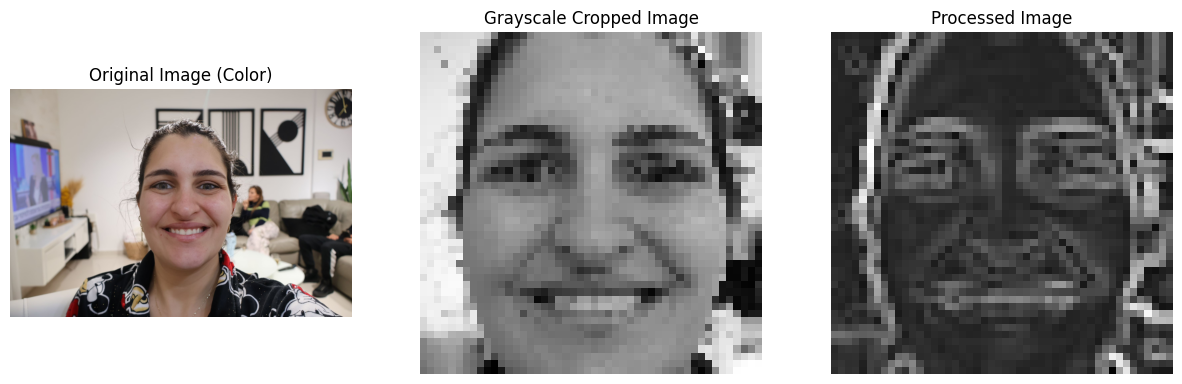

--------------------------------------------------------------------------------
Prediction Scores:
angry: 0.1032
disgusted: 0.0050
fearful: 0.2173
happy: 0.3448
neutral: 0.0307
sad: 0.0499
surprised: 0.2491
True Label: surprised | Predicted: happy ❌


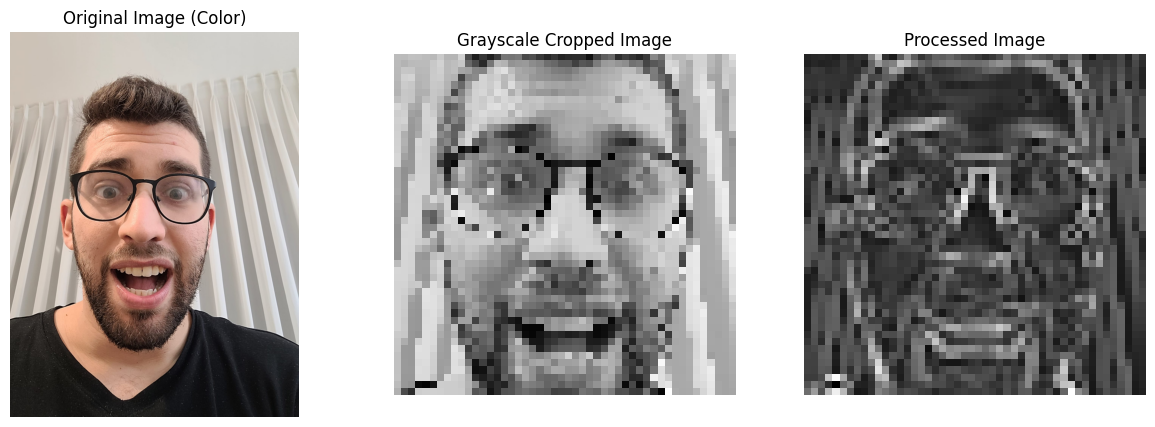

--------------------------------------------------------------------------------


In [113]:
# Function to crop the face from an image using Haar cascades
def crop_face(image):
    image_rgb = np.array(image)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_image = gray[y:y+h, x:x+w]
        return face_image
    else:
        return gray  # Return grayscale image if no face is detected

# Load and prepare image: crop face and resize to 48x48
def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image_gray = crop_face(image)
    image_resized = cv2.resize(image_gray, (48, 48), interpolation=cv2.INTER_LANCZOS4)
    image_array = np.array(image_resized)
    return image_array, image

# Apply Sobel edge filtering, lighting correction, and sharpening
def process_image(image_array):
    sobel_image = filters.sobel(image_array)
    img_corrected = exposure.rescale_intensity(sobel_image, in_range=(0, 1), out_range=(0, 255))
    sharpened = cv2.GaussianBlur(img_corrected, (5, 5), 0)
    sharpened = cv2.addWeighted(img_corrected, 1.5, sharpened, -0.5, 0)
    return sharpened

# Plot original, grayscale, and processed images
def display_images(original, gray, processed):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original)
    plt.title("Original Image (Color)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Cropped Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(processed, cmap='gray')
    plt.title("Processed Image")
    plt.axis('off')

    plt.show()

# Predict the emotion using a trained model
def predict_emotion(image_array, verbose=False):
    image_array = image_array / 255.0
    image_array = image_array.reshape(1, 48, 48, 1)
    predictions = model_sobel.predict(image_array, verbose=0)
    labels = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]
    predicted_label = np.argmax(predictions, axis=1)[0]
    predicted_label_name = labels[predicted_label]

    # Only print scores if verbose is True
    if verbose:
        print("Prediction Scores:")
        for i, label in enumerate(labels):
            print(f"{label}: {predictions[0][i]:.4f}")

    return predicted_label_name, predictions



# Process all images in a given directory and collect results
def process_directory(directory_path, max_display=5, verbose=True):
    true_labels = []
    predicted_labels = []
    count = 0  # Counter for how many images we've printed

    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file)
            true_label = file.split()[0]  # Extract label from filename
            img_array, img_original = load_and_preprocess_image(file_path)
            img_gray = crop_face(Image.open(file_path))
            img_processed = process_image(img_array)
            predicted_label, predictions = predict_emotion(img_processed, verbose=(count < max_display and verbose))

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

            # Only display the first N images
            if verbose and count < max_display:
                correct = "✅" if true_label == predicted_label else "❌"
                print(f"True Label: {true_label} | Predicted: {predicted_label} {correct}")
                display_images(img_original, img_array, img_processed)
                print("-" * 80)
                count += 1

    return true_labels, predicted_labels


# Run on directory
true_labels, predicted_labels = process_directory(image_path, max_display=5, verbose=True)

After making predictions, we compute a confusion matrix and classification report to evaluate model performance on the real-world images.

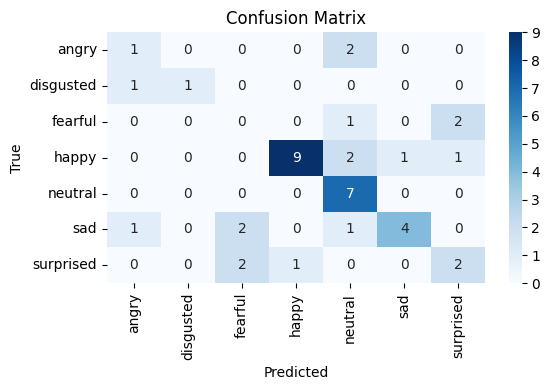

Classification Report:
              precision    recall  f1-score   support

       angry       0.33      0.33      0.33         3
   disgusted       1.00      0.50      0.67         2
     fearful       0.00      0.00      0.00         3
       happy       0.90      0.69      0.78        13
     neutral       0.54      1.00      0.70         7
         sad       0.80      0.50      0.62         8
   surprised       0.40      0.40      0.40         5

    accuracy                           0.59        41
   macro avg       0.57      0.49      0.50        41
weighted avg       0.66      0.59      0.59        41



In [114]:
# Get the full list of class labels from the LabelEncoder
all_labels = le.classes_

# Create a DataFrame to store true and predicted labels
results_df = pd.DataFrame({
    "True": true_labels,
    "Predicted": predicted_labels
})

# Re-encode string labels to integers for metrics calculation
y_true_encoded = le.transform(results_df["True"])
y_pred_encoded = le.transform(results_df["Predicted"])

# Confusion Matrix - with consistent label order
conf_matrix = pd.crosstab(
    results_df["True"],
    results_df["Predicted"],
    rownames=["True"],
    colnames=["Predicted"],
    dropna=False
).reindex(index=all_labels, columns=all_labels, fill_value=0)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Print full classification report with all labels included
print("Classification Report:")
print(classification_report(
    y_true_encoded,
    y_pred_encoded,
    labels=range(len(all_labels)),
    target_names=all_labels,
    zero_division=0  # Avoid division by zero if a class is missing
))

**Summary of Results – Personal Images**

The trained model was evaluated on **41 real-world images**, achieving an overall accuracy of **59%**.

- The model performed **strongly on "happy"** (F1-score of **0.78**) and **"neutral"** (F1-score of **0.70**), showing good generalization on these emotions.  
- **"Sad"** and **"disgusted"** had mixed results – high precision but moderate recall, suggesting partial recognition.  
- The model **struggled significantly with "fearful"**, with a recall and F1-score of **0.00**, indicating complete misclassification.  
- Performance on **"angry"** and **"surprised"** was weak and inconsistent, with F1-scores around **0.33–0.40**.

---

**Comparison to FER-2013 Test Set**

| Metric             | FER-2013 Test Set | Personal Images |
|-------------------|------------------:|----------------:|
| Accuracy           | 58.99%            | 59%             |
| Macro F1-score     | 0.55              | 0.50            |
| Weighted F1-score  | 0.58              | 0.59            |

---

Despite a small and diverse test set, the model **maintained similar overall accuracy** to the FER-2013 benchmark.  
However, **macro F1-score dropped slightly**, reflecting uneven performance across classes, especially on underrepresented or subtle emotions like *fearful*.


# **10. Conclusion**

In this project, we explored the task of facial emotion recognition using deep learning techniques on the FER-2013 dataset.  
We evaluated multiple preprocessing approaches — including raw grayscale images, Sobel-filtered images, and HOG features — and trained three types of models:  
a Support Vector Machine (SVM), a custom Convolutional Neural Network (CNN), and a transfer learning model based on EfficientNetB0.

Our results showed that:
- The **EfficientNetB0** model achieved the best performance on the test set, with an accuracy of **62.87%** and strong results for clearly expressed emotions like *happy* and *surprised*.
- The **CNN trained on raw grayscale images** performed slightly better than the one trained on Sobel-enhanced images, suggesting that edge enhancement may suppress subtle facial features valuable to convolutional layers.
- The **SVM with HOG features** performed reasonably well considering its simplicity, but was outperformed by deep models.

We also applied the trained CNN model to a set of real-world personal images.  
While the model correctly predicted many emotions, it struggled with underrepresented or subtle expressions, and its macro-average F1-score dropped — highlighting the challenges of generalizing to small, diverse, and uncontrolled datasets.

Overall, this project demonstrates the potential of deep learning for emotion recognition, while also emphasizing the importance of data quality, balanced class representation, and preprocessing strategies.  
Further improvements could include training on larger and more diverse datasets, incorporating facial landmarks, or using attention mechanisms to focus on key facial regions.



# **11. Personal summary**

During the semester, I had a unique opportunity to combine theoretical learning with practical work.
Alongside the Data Science Workshop course, I also participated in a seminar on Artificial Intelligence that focused on emotion recognition using deep learning.
In the seminar, I deepened my understanding of the field from a theoretical perspective: I explored current challenges, surveyed various datasets, compared different model architectures, and examined ethical considerations related to the implementation of emotion recognition systems.

The combination of the seminar and the hands-on project in the workshop allowed me to apply the knowledge I had acquired — to build, train, and compare different models, to understand the importance of preprocessing and adapting to real-world challenges, and to evaluate model performance on personal images I took myself.

Throughout the project, I also faced several technological challenges:
Working with a dataset like FER-2013, which contains "only" about 30,000 images, presented difficulties compared to models trained on millions of examples (such as ImageNet).
Using deep models like EfficientNet or CNNs requires a delicate balance between model complexity and the risk of overfitting or underfitting.
Moreover, training demanded considerable computation time, even when using a GPU.
I learned how to make thoughtful decisions about model architecture, batch size, number of epochs, and hyperparameters — all while taking into account compute limitations and time constraints.

This project reinforced my understanding that deep learning is not just a technical tool, but also a field that requires human sensitivity, critical thinking, and deep contextual understanding of where and how models operate.
Exploring emotion recognition connected my knowledge in data science to a socially and emotionally meaningful domain with real technological potential.

Given the strong interest and foundation I developed through this project, I plan to continue improving the model in the future — enhancing its performance on real-world images, improving accuracy in identifying less distinct emotions, and potentially integrating the system into interactive applications for early emotion recognition in toddlers, to help detect early social challenges or highlight meaningful and joyful moments for parents.